#Step1: Preprocessing and EDA

First I make sure Colab has everything I need for this project.

In [ ]:
!pip install pandas numpy networkx matplotlib

I imported the exact tools I’ll use throughout: pandas/numpy, regex and ast because in relationships.csv a bunch of fields are stored as text lists and I’ll need to clean/parse them, networkx for the actual network, matplotlib for visuals, and Counter/defaultdict for fast tallying and grouping.

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


Loaded the datasets, and had a look through them

In [ ]:
artists = pd.read_csv("artists.csv")
rels = pd.read_csv("relationships.csv")
institutions = pd.read_csv("institutions.csv")
schools = pd.read_csv("schools.csv")

print(artists.shape, rels.shape, institutions.shape, schools.shape)
artists.head(3)


(2996, 7) (2996, 8) (73, 4) (220, 2)


artistUrl                        id  \
0  /en/ancient-egyptian-painting  5d230b31edc2c9fb74ae130a   
1      /en/ancient-greek-pottery  5ced09b1edc2c993247c1ea0   
2     /en/ancient-greek-painting  5ce3c54dedc2c921c4035b7d   

                                               image     nation  \
0  https://uploads2.wikiart.org/00244/images/anci...  Egyptians   
1  https://uploads7.wikiart.org/00238/images/anci...     Greeks   
2  https://uploads8.wikiart.org/00237/images/anci...     Greeks   

                                  title totalWorksTitle                  year  
0                         Ancient Egypt    169 artworks  c.3150 BC - c.640 AD  
1                 Ancient Greek Pottery     87 artworks         c.900 - 31 BC  
2  Ancient Greek Painting and Sculpture     76 artworks       c.700 - c.31 BC

In [ ]:
rels.head()

artistUrl friends               influenced_by  \
0                    /en/apelles     NaN  /en/ancient-greek-painting   
1                   /en/wang-wei     NaN                         NaN   
2  /en/ancient-egyptian-painting     NaN                         NaN   
3                    /en/guanxiu     NaN                         NaN   
4                    /en/han-gan     NaN                         NaN   

                                       influenced_on institution  \
0                         /en/ancient-greek-painting         NaN   
1                                                NaN         NaN   
2  /en/fayum-portrait,/en/ancient-greek-painting,...         NaN   
3                                                NaN         NaN   
4                                                NaN         NaN   

                                           movements  \
0  Classical Period (480 - 323 BC),Hellenistic Pe...   
1                             Tang Dynasty (618–907)   
2  Early Dynastic Period (3150 – 2686 BC),Old Kin...   
3  Tang Dynasty (618–907),Five Dynasties and Ten ...   
4                             Tang Dynasty (618–907)   

                                              school         type  
0  /en/artists-by-painting-school/heptanese-ionia...      Artists  
1                                                NaN      Artists  
2                                                NaN  Collections  
3                                                NaN      Artists  
4                                                NaN      Artists

In [ ]:
institutions.head()

city  country                                              title  \
0      NaN      NaN                                Guild of Saint Luke   
1  Antwerp  Belgium                         Royal Academy of Fine Arts   
2   Munich  Germany  Akademie der Bildenden Künste München (Munich ...   
3    Milan    Italy   Accademia di Belle Arti di Brera (Brera Academy)   
4    Paris   France                            Académie des Beaux-Arts   

                                                 url  
0  /en/artists-by-art-institution/guild-of-saint-...  
1  /en/artists-by-art-institution/royal-academy-o...  
2        /en/artists-by-art-institution/akademie-der  
3  /en/artists-by-art-institution/accademia-di-be...  
4  /en/artists-by-art-institution/acad-mie-des-beaux

In [ ]:
schools.head()

title                                               url
0     Flemish School     /en/artists-by-painting-school/flemish-school
1     Sienese School     /en/artists-by-painting-school/sienese-school
2     Umbrian school     /en/artists-by-painting-school/umbrian-school
3  Florentine School  /en/artists-by-painting-school/florentine-school
4       Parma school       /en/artists-by-painting-school/parma-school

I quickly checked missingness with .isnull().sum() just to know where the gaps are. I’m not dropping any of these because the absence is meaningful signal in a network, and deleting rows would bias the graph and kill isolates.

In [ ]:
artists.isnull().sum()

artistUrl           0
id                  0
image               0
nation             32
title               0
totalWorksTitle     0
year                1
dtype: int64

In [ ]:
rels.isnull().sum()

artistUrl           0
friends          2580
influenced_by    2512
influenced_on    2637
institution      2362
movements          40
school           1966
type                1
dtype: int64

In [ ]:
institutions.isnull().sum()

city       2
country    2
title      0
url        0
dtype: int64

In [ ]:
schools.isnull().sum()

title    0
url      0
dtype: int64

Here I standardize the column names so joins and lookups don’t break later. I strip spaces, collapse multi-spaces, convert CamelCase to snake_case, and lowercase everything, this way I won’t fight with typos or case sensitivity in NetworkX attributes. I’m not touching the cell values themselves, only the headers. Finally, I force the key to be identical by renaming artist_url to artisturl in both artists and rels, so the same field name can be used as the join key when I wire up edges from the relationships table to the artist nodes.

In [ ]:
def normalize_cols(df):
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.replace(r"([a-z])([A-Z])", r"\1_\2", regex=True)
                  .str.lower())
    return df

artists = normalize_cols(artists)
rels = normalize_cols(rels)
institutions = normalize_cols(institutions)
schools = normalize_cols(schools)


artists.rename(columns={"artist_url":"artisturl"}, inplace=True, errors="ignore")
rels.rename(columns={"artist_url":"artisturl"}, inplace=True, errors="ignore")


As you can see column names are changed.

In [ ]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996 entries, 0 to 2995
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   artisturl          2996 non-null   object
 1   id                 2996 non-null   object
 2   image              2996 non-null   object
 3   nation             2964 non-null   object
 4   title              2996 non-null   object
 5   total_works_title  2996 non-null   object
 6   year               2995 non-null   object
dtypes: object(7)
memory usage: 164.0+ KB


In [ ]:
rels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996 entries, 0 to 2995
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artisturl      2996 non-null   object
 1   friends        416 non-null    object
 2   influenced_by  484 non-null    object
 3   influenced_on  359 non-null    object
 4   institution    634 non-null    object
 5   movements      2956 non-null   object
 6   school         1030 non-null   object
 7   type           2995 non-null   object
dtypes: object(8)
memory usage: 187.4+ KB


In [ ]:
institutions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   city     71 non-null     object
 1   country  71 non-null     object
 2   title    73 non-null     object
 3   url      73 non-null     object
dtypes: object(4)
memory usage: 2.4+ KB


In [ ]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   220 non-null    object
 1   url     220 non-null    object
dtypes: object(2)
memory usage: 3.6+ KB


Here I’m cleaning the “list-like” columns so they become real Python lists before building edges with parse_listish. Yes, not all rows can be in such format, however to be more confident, I decided to clean every row.

In [ ]:
import ast, re, numpy as np, pandas as pd

def parse_listish(x):
    if x is None:
        return []

    if isinstance(x, (list, tuple, set, np.ndarray)):
        return [str(v).strip() for v in list(x) if str(v).strip()]

    if np.isscalar(x) and pd.isna(x):
        return []

    s = str(x).strip()
    if s == "":
        return []
    try:
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple, set)):
            return [str(v).strip() for v in val if str(v).strip()]
    except Exception:
        pass

    s = re.sub(r"^[\[\(\{]\s*|\s*[\]\)\}]\s*$", "", s)
    parts = re.split(r"\s*,\s*|\s*;\s*|\s*\|\s*|\s*\n\s*", s)
    return [p for p in parts if p]


I’m not touching keys like artisturl or type, because converting those would break joins. The result is that missing values become [], valid strings become clean lists of “/en/…” tokens, and I can safely iterate these columns to create edges later.

In [ ]:
list_cols_rels = ["friends", "influenced_by", "influenced_on", "institution", "movements", "school"]
for c in list_cols_rels:
    if c in rels.columns:
        rels[c] = rels[c].apply(parse_listish)


I’m pulling the first number out of total_works_title and turning it into a numeric column, so “169 artworks” becomes 169 as a float. Then cleaned a few string fields like nation, title, and year by forcing them to text and trimming spaces

In [ ]:
artists["total_works"] = pd.to_numeric(artists.get("total_works_title", pd.Series(np.nan, index=artists.index)).astype(str).str.extract(r"(\d+)", expand=False), errors="coerce")


for c in ["nation","title","year"]:
    artists[c] = artists[c].astype(str).str.strip()

Just to see how total_works column looks like

In [ ]:
artists.head()

artisturl                        id  \
0  /en/ancient-egyptian-painting  5d230b31edc2c9fb74ae130a   
1      /en/ancient-greek-pottery  5ced09b1edc2c993247c1ea0   
2     /en/ancient-greek-painting  5ce3c54dedc2c921c4035b7d   
3                    /en/apelles  5ba232ccedc2c918cc654ea8   
4             /en/fayum-portrait  5beea1ededc2c915a01acdda   

                                               image     nation  \
0  https://uploads2.wikiart.org/00244/images/anci...  Egyptians   
1  https://uploads7.wikiart.org/00238/images/anci...     Greeks   
2  https://uploads8.wikiart.org/00237/images/anci...     Greeks   
3  https://uploads2.wikiart.org/00202/images/apel...      Greek   
4  https://uploads7.wikiart.org/00210/images//01....  Egyptians   

                                  title total_works_title  \
0                         Ancient Egypt      169 artworks   
1                 Ancient Greek Pottery       87 artworks   
2  Ancient Greek Painting and Sculpture       76 artworks   
3                               Apelles        8 artworks   
4                        Fayum portrait       76 artworks   

                   year  total_works  
0  c.3150 BC - c.640 AD          169  
1         c.900 - 31 BC           87  
2       c.700 - c.31 BC           76  
3         born c.370 BC            8  
4          c.50 - c.250           76

Then I checked each relationships row to see if it has at least one link in any of the edge fields. Even if friends is empty, the same row may still have influenced_by or a school or institution. The print shows 2973 out of 2996 rows have some edge to contribute, so dropping rows just because one column is null would throw away real connections. That’s exactly why I kept the nulls.

In [ ]:
usable = 0
total = len(rels)
for _, r in rels.iterrows():
    if any(len(r.get(col, [])) for col in ["friends", "influenced_by", "influenced_on", "institution", "school", "movements"]):
        usable += 1
print(f"Rows with at least one potential edge: {usable}/{total} = {usable/total:.1%}")


Rows with at least one potential edge: 2973/2996 = 99.2%


Wrote a tiny helper to summarize any list-like column. This lets me quickly see the most common friends, schools, institutions, or movements without writing the same cleaning code over and over.

In [ ]:
def explode_counts(df, col, top=20):
    if col not in df.columns:
        return pd.DataFrame({col:[], "count":[]})
    x = df[col]
    ser = (x.apply(lambda v: v if isinstance(v, (list,tuple,set)) else ([] if pd.isna(v) else [str(v)]))
             .explode()
             .dropna()
             .astype(str)
             .str.strip()
             .replace("", np.nan)
             .dropna())
    vc = ser.value_counts()
    out = vc.head(top).rename_axis(col).reset_index(name="count")
    return out

Let's see the distribution of movements. From the output we see Romanticism, Impressionism, Expressionism, and Realism dominate, total movement mentions are 4263, and about 2956 artists have at least one movement

movements  count
0                  Romanticism    254
1                Impressionism    209
2                Expressionism    201
3                      Realism    192
4       Abstract Expressionism    153
5                   Surrealism    152
6                      Baroque    145
7                 Abstract Art    143
8           Post-Impressionism    130
9                 Contemporary    109
10                 Art Nouveau     94
11                     Pop Art     91
12                  Minimalism     87
13                Academic Art     86
14                   Symbolism     83
15                Art Informel     81
16  Post-Painterly Abstraction     75
17                      Cubism     74
18              Conceptual Art     67
19               Neoclassicism     59
20           Neo-Expressionism     57
21                      Rococo     54
22            Dutch Golden Age     51
23                      Op Art     50
24        Contemporary Realism     46

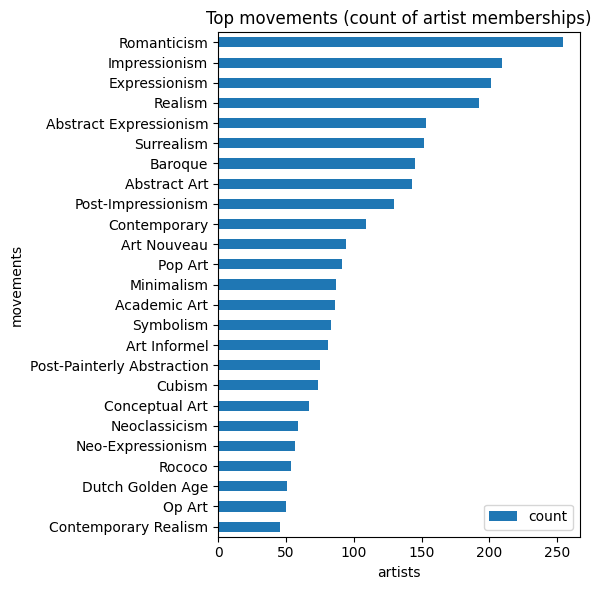

Total movement mentions: 4263
Artists with >=1 movement: 2956


In [ ]:
top_mv = explode_counts(rels, "movements", top=25)
display(top_mv)

ax = top_mv.iloc[::-1].plot(kind="barh", x="movements", y="count", figsize=(6,6), title="Top movements (count of artist memberships)")
ax.set_xlabel("artists")
plt.tight_layout(); plt.show()

total_mv_mentions = rels["movements"].apply(lambda v: len(v) if isinstance(v, (list,tuple,set)) else (0 if pd.isna(v) else 1)).sum()
print("Total movement mentions:", total_mv_mentions)
print("Artists with >=1 movement:", (rels["movements"].apply(lambda v: isinstance(v,(list,tuple,set)) and len(v)>0)).sum())


Here I’m just looking at the nationality distribution. I count artists by nation, plot the top 20, and add a cumulative share to see how concentrated it is. We can see Americans lead, and by the time we add French, Italian, British, and German we already cover about half of the dataset, with the rest forming a long tail.

count
nation           
American      520
French        402
Italian       269
British       249
German        160
Russian       108
Dutch         105
Spanish        87
Romanian       78
Japanese       67
Ukrainian      58
Portuguese     52
Swiss          47
Austrian       46
Chinese        43
Flemish        40
Polish         38
Belgian        36
Australian     36
Canadian       35
Brazilian      35
Jewish         33
nan            32
Hungarian      30
Mexican        29

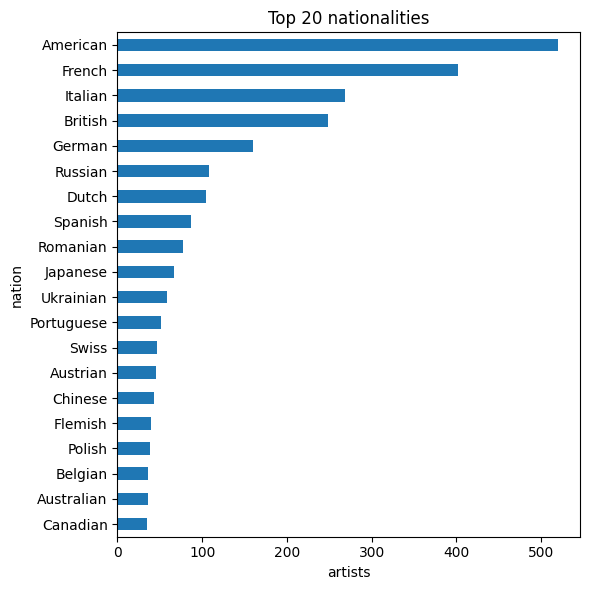

nation  cum_share
0     American   0.173565
1       French   0.307744
2      Italian   0.397530
3      British   0.480641
4       German   0.534045
5      Russian   0.570093
6        Dutch   0.605140
7      Spanish   0.634179
8     Romanian   0.660214
9     Japanese   0.682577
10   Ukrainian   0.701936
11  Portuguese   0.719292
12       Swiss   0.734980
13    Austrian   0.750334
14     Chinese   0.764686
15     Flemish   0.778037
16      Polish   0.790721
17     Belgian   0.802737
18  Australian   0.814753
19    Canadian   0.826435
20   Brazilian   0.838117
21      Jewish   0.849132
22         nan   0.859813
23   Hungarian   0.869826
24     Mexican   0.879506

In [ ]:
nat = (artists["nation"].fillna("Unknown").astype(str).str.strip())
nat_counts = nat.value_counts()
display(nat_counts.head(25).to_frame("count"))

ax = nat_counts.head(20).iloc[::-1].plot(kind="barh", figsize=(6,6), title="Top 20 nationalities")
ax.set_xlabel("artists")
plt.tight_layout(); plt.show()


Here I rank artists by number of artworks using the numeric total_works we extracted, then show the top 25 and a bar chart. From the result we see a very skewed distribution: Van Gogh and Nicholas Roerich are out in front near the ~2k mark, followed by Renoir, Monet, Dalí, Picasso and others. Counts drop off fast after the first dozen.

artisturl                 artist nationality  total_works
0        /en/vincent-van-gogh       Vincent van Gogh       Dutch         1931
1        /en/nicholas-roerich       Nicholas Roerich     Russian         1843
2   /en/pierre-auguste-renoir  Pierre-Auguste Renoir      French         1412
3            /en/claude-monet           Claude Monet      French         1367
4           /en/salvador-dali          Salvador Dali     Spanish         1178
5           /en/pablo-picasso          Pablo Picasso     Spanish         1170
6      /en/theophile-steinlen     Theophile Steinlen      French         1128
7             /en/bela-czobel            Bela Czobel      Jewish         1040
8            /en/marc-chagall           Marc Chagall      French         1022
9           /en/henri-matisse          Henri Matisse      French         1007
10     /en/pyotr-konchalovsky     Pyotr Konchalovsky     Russian          925
11       /en/camille-pissarro       Camille Pissarro      French          889
12         /en/albrecht-durer         Albrecht Durer      German          844
13    /en/john-singer-sargent    John Singer Sargent    American          799
14              /en/rembrandt              Rembrandt       Dutch          767
15           /en/gustave-dore           Gustave Dore      French          760
16    /en/alfred-freddy-krupa    Alfred Freddy Krupa    Croatian          752
17    /en/hryhorii-havrylenko    Hryhorii Havrylenko   Ukrainian          714
18     /en/zdzislaw-beksinski     Zdzislaw Beksinski      Polish          708
19        /en/ivan-aivazovsky        Ivan Aivazovsky     Russian          693
20        /en/boris-kustodiev        Boris Kustodiev     Russian          645
21            /en/edgar-degas            Edgar Degas      French          626
22      /en/peter-paul-rubens      Peter Paul Rubens     Flemish          615
23           /en/paul-cezanne           Paul Cezanne      French          588
24          /en/eugene-boudin          Eugene Boudin      French          560

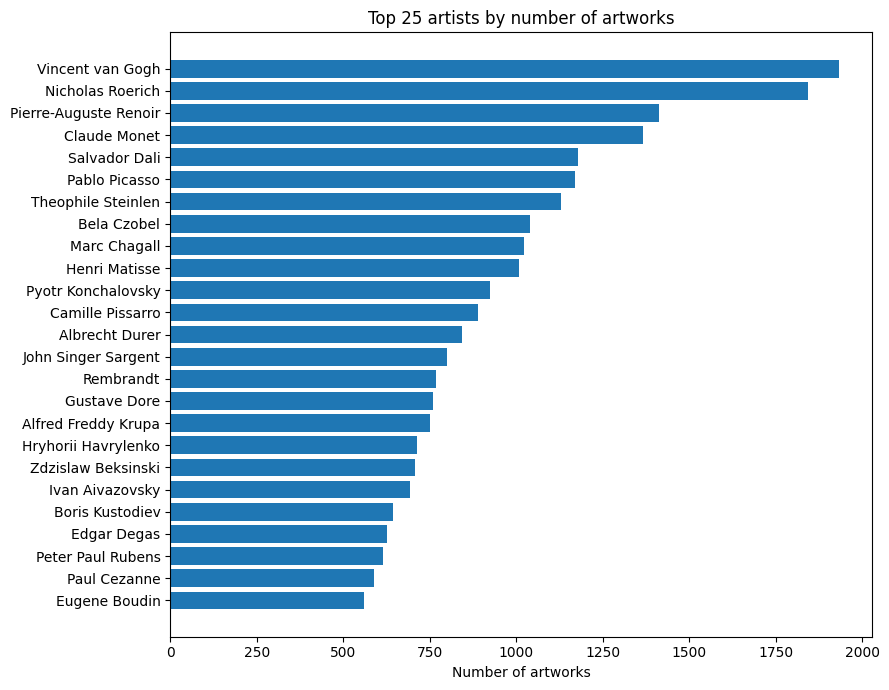

In [ ]:
df = artists.dropna(subset=["total_works"]).copy()
df["total_works"] = pd.to_numeric(df["total_works"], errors="coerce")

top = (df[["artisturl", "title", "nation", "total_works"]]
       .sort_values("total_works", ascending=False)
       .head(25)
       .reset_index(drop=True))

display(top.rename(columns={"title":"artist", "nation":"nationality"}))

plt.figure(figsize=(9, 7))
plt.barh(top["title"][::-1], top["total_works"][::-1])
plt.xlabel("Number of artworks")
plt.title(f"Top 25 artists by number of artworks")
plt.tight_layout()
plt.show()

# Step 2: Networkx

I’m initializing the network and loading all node types. Each artist becomes a node keyed by their artisturl with attributes like name, nation, years, image, and total_works. I also add school and institution nodes so I can later connect artists to them. I prefer the canonical URL as the node ID, tagging type="school" or type="institution" to keep them distinct. The print confirms the base graph size is 3,289 nodes.

In [ ]:
G = nx.DiGraph()

for _, r in artists.iterrows():
    aid = r.get("artisturl")
    if pd.isna(aid):
        continue
    aid = str(aid)
    G.add_node(aid,
               type="artist",
               name=r.get("title"),
               nation=r.get("nation"),
               total_works=r.get("total_works"),
               year=r.get("year"),
               image=r.get("image"))

for _, r in schools.iterrows():
    sid = r.get("url") if pd.notna(r.get("url")) else r.get("title")
    if pd.isna(sid): continue
    sid = f"school::{sid}"
    G.add_node(sid, type="school", name=r.get("title"))

for _, r in institutions.iterrows():
    iid = r.get("url") if pd.notna(r.get("url")) else r.get("title")
    if pd.isna(iid): continue
    iid = f"institution::{iid}"
    G.add_node(iid, type="institution",
               name=r.get("title"),
               city=r.get("city"),
               country=r.get("country"))

print("Initial nodes:", G.number_of_nodes())


Initial nodes: 3289


I listed a couple of artist nodes to see their attributes

In [ ]:
len([n for n,d in G.nodes(data=True) if d.get("type")=="artist"]), list(G.nodes(data=True))[:2]

(2996,
 [('/en/ancient-egyptian-painting',
   {'type': 'artist',
    'name': 'Ancient Egypt',
    'nation': 'Egyptians',
    'total_works': 169,
    'year': 'c.3150 BC - c.640 AD',
    'image': 'https://uploads2.wikiart.org/00244/images/ancient-egyptian-painting/stela-of-aafenmut-ca-924-889-b-c.jpg!PinterestLarge.jpg'}),
  ('/en/ancient-greek-pottery',
   {'type': 'artist',
    'name': 'Ancient Greek Pottery',
    'nation': 'Greeks',
    'total_works': 87,
    'year': 'c.900 - 31 BC',
    'image': 'https://uploads7.wikiart.org/00238/images/ancient-greek-pottery/hb-14-136-av5-1.jpg!PinterestLarge.jpg'})])

We can see here that the total number of nodes correspond.

In [ ]:
from collections import Counter
Counter(d["type"] for _,d in G.nodes(data=True))

Counter({'artist': 2996, 'school': 220, 'institution': 73})

Just to see the atributes of random artist

In [ ]:
some_artist = next(n for n,d in G.nodes(data=True) if d["type"]=="artist")
G.nodes[some_artist]

{'type': 'artist',
 'name': 'Ancient Egypt',
 'nation': 'Egyptians',
 'total_works': 169,
 'year': 'c.3150 BC - c.640 AD',
 'image': 'https://uploads2.wikiart.org/00244/images/ancient-egyptian-painting/stela-of-aafenmut-ca-924-889-b-c.jpg!PinterestLarge.jpg'}

Here I’m making school and institution references consistent so edges land on the same node even if the source is messy.

In [ ]:
def norm_title(s: str) -> str:
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]+", "", s)
    return s

school_url_to_id, school_title_to_id = {}, {}
for _, r in schools.iterrows():
    url = r.get("url")
    title = r.get("title")
    if pd.notna(url):
        school_url_to_id[str(url).strip()] = f"school::{str(url).strip()}"
    if pd.notna(title):
        school_title_to_id[norm_title(title)] = (f"school::{str(url).strip()}"
                                                 if pd.notna(url)
                                                 else f"school::{norm_title(title)}")


inst_url_to_id, inst_title_to_id = {}, {}
for _, r in institutions.iterrows():
    url = r.get("url")
    title = r.get("title")
    if pd.notna(url):
        inst_url_to_id[str(url).strip()] = f"institution::{str(url).strip()}"
    if pd.notna(title):
        inst_title_to_id[norm_title(title)] = (f"institution::{str(url).strip()}"
                                               if pd.notna(url)
                                               else f"institution::{norm_title(title)}")

def resolve_school(value: str) -> str:
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    v = str(value).strip()
    if v in school_url_to_id:
        return school_url_to_id[v]
    vt = norm_title(v)
    if vt in school_title_to_id:
        return school_title_to_id[vt]
    return f"school::{v}"

def resolve_institution(value: str) -> str:
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    v = str(value).strip()
    if v in inst_url_to_id:
        return inst_url_to_id[v]
    vt = norm_title(v)
    if vt in inst_title_to_id:
        return inst_title_to_id[vt]
    return f"institution::{v}"


Here I’m actually connecting the network. For each artist I add directed “influenced” links, undirected “friend” links, and affiliation links from the artist to their schools and institutions. If the same pair shows up multiple times I just increase the edge weight instead of duplicating it, and I ignore self-loops. If a relation points to an artist that wasn’t in the table, I create that node so the edge isn’t lost.

In [ ]:
ALLOW_SELF_LOOPS = False
CREATE_MISSING_ARTISTS = True

def ensure_artist(nlike, create=CREATE_MISSING_ARTISTS):
    if nlike is None: return None
    a = str(nlike).strip()
    if a in G and G.nodes[a].get("type")=="artist":
        return a
    if create:
        G.add_node(a, type="artist", name=(G.nodes[a]["name"] if a in G else a))
        return a
    return None

def add_edge_weighted(u, v, rel):
    if u is None or v is None:
        return
    if (not ALLOW_SELF_LOOPS) and (u == v):
        return
    if G.has_edge(u, v):
        G[u][v]["weight"] = G[u][v].get("weight", 0) + 1
        rels = G[u][v].get("rels_set", set())
        rels.add(rel)
        G[u][v]["rels_set"] = rels
    else:
        G.add_edge(u, v, rel=rel, weight=1, rels_set={rel})

def add_undirected_weighted(u, v, rel):
    add_edge_weighted(u, v, rel)
    add_edge_weighted(v, u, rel)

G.remove_edges_from(list(G.edges()))

rows = 0
for _, r in rels.iterrows():
    rows += 1
    src = r.get("artisturl")
    if pd.isna(src):
        continue
    src = ensure_artist(src)

    for tgt in r.get("influenced_on", []):
        t = ensure_artist(tgt)
        add_edge_weighted(src, t, "influenced")

    for origin in r.get("influenced_by", []):
        o = ensure_artist(origin)
        add_edge_weighted(o, src, "influenced")

    for f in r.get("friends", []):
        fid = ensure_artist(f)
        add_undirected_weighted(src, fid, "friend")

    for s in r.get("school", []):
        sid = resolve_school(s)
        if sid is None:
            continue
        if sid not in G:
            G.add_node(sid, type="school", name=str(s))
        add_undirected_weighted(src, sid, "member_of")

    for inst in r.get("institution", []):
        iid = resolve_institution(inst)
        if iid is None:
            continue
        if iid not in G:
            G.add_node(iid, type="institution", name=str(inst))
        add_undirected_weighted(src, iid, "studied_at")

print(f"Processed relationship rows: {rows}")
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


Processed relationship rows: 2996
Nodes: 3516 Edges: 6649


I break down edges by relation type to see what dominates, and check two integrity things: self-loops and any non-positive weights. Result looks clean, most edges are affiliations (member_of, studied_at), then influence and friends, zero self-loops, and no weird less than 0 weights, so the aggregation logic did what we wanted.

In [ ]:
from collections import Counter

rel_counts = Counter(d.get("rel") for _,_,d in G.edges(data=True))
print("Edge counts by rel:", rel_counts)

self_loops = sum(1 for u,v in G.edges() if u==v)
print("Self-loops:", self_loops)

neg_or_zero_w = sum(1 for _,_,d in G.edges(data=True) if d.get("weight",1) <= 0)
print("Non-positive weights:", neg_or_zero_w)


Edge counts by rel: Counter({'member_of': 2652, 'studied_at': 1670, 'influenced': 1396, 'friend': 931})
Self-loops: 0
Non-positive weights: 0


Here I’m checking how many nodes were created only through the relationships. The counts show 159 extra artists, 53 extra schools, and 15 extra institutions. That matches the earlier logic where I allow edges to bring in missing entities, so the graph stays connected even if a table didn’t list them.

In [ ]:
extra_artists = {n for n,d in G.nodes(data=True) if d.get("type")=="artist"} - set(artists["artisturl"].astype(str))
extra_schools  = {n for n,d in G.nodes(data=True) if d.get("type")=="school"}  - {f"school::{u}" for u in schools["url"].astype(str)}
extra_insts    = {n for n,d in G.nodes(data=True) if d.get("type")=="institution"} - {f"institution::{u}" for u in institutions["url"].astype(str)}

len(extra_artists), len(extra_schools), len(extra_insts)

(159, 53, 15)

Here we can see that the number of unique movements are 202

In [ ]:
n_unique_movements = (
    pd.Series(rels["movements"]).explode().dropna().astype(str).str.strip().nunique()
)
print(n_unique_movements)


202


And then I turned art movements into their own nodes. I clean each movement title to a stable id like movement::impressionism, add it if it’s not already in the graph, and keep a count. Result: 177 movement nodes added, total nodes now 3693, so we can link artists directly to movements later instead of treating movements as plain text.

In [ ]:
import re

def norm_title(s: str) -> str:
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]+", "", s)
    return s

def movement_id_from_title(title: str) -> str:
    return f"movement::{norm_title(title)}"

added = 0
if "movements" in rels.columns:
    for _, r in rels.iterrows():
        for mv in r.get("movements", []):
            mid = movement_id_from_title(mv)
            if mid not in G:
                G.add_node(mid, type="movement", name=str(mv))
                added += 1
print(f"Added movement nodes: {added}  |  Total nodes now: {G.number_of_nodes()}")


Added movement nodes: 177  |  Total nodes now: 3693


I’m validating why movements drop from 202 to 177. I take the raw labels, normalize them to a consistent form, and compare uniques. The table shows collisions where multiple raw strings collapse into the same normalized movement, so things like punctuation, casing, or extra text map to one ID. That’s exactly why we add 177 movement nodes instead of 202.

In [ ]:
mv_raw = (
    pd.Series(rels["movements"])
      .explode().dropna().astype(str).str.strip()
)

mv_norm = mv_raw.str.lower().str.replace(r"\s+", " ", regex=True)\
                .str.replace(r"[^a-z0-9 ]+", "", regex=True)

print("raw uniques:", mv_raw.nunique(), "normalized uniques:", mv_norm.nunique())

collisions = (
    pd.DataFrame({"raw": mv_raw, "norm": mv_norm})
      .drop_duplicates()
      .groupby("norm")["raw"].agg(list)
      .loc[lambda s: s.str.len() > 1]
      .head(20)
)
collisions


raw uniques: 202 normalized uniques: 177


norm
concrete art concretism                   [Concrete Art (Concretism), Concrete Art (Conc...
de stijl neoplasticism                    [De Stijl (Neoplasticism), De Stijl (Neoplasti...
edo period 16031867                         [Edo period (1603–1867, Edo period (1603–1867)]
environmental art land art                [Environmental Art (Land art, Environmental Ar...
five dynasties and ten kingdoms 907960    [Five Dynasties and Ten Kingdoms (907–960, Fiv...
harlem renaissance new negro movement     [Harlem Renaissance (New Negro Movement, Harle...
haute pte matter painting                 [Haute Pâte (Matter Painting), Haute Pâte (Mat...
hyperrealism                                                [Hyper-Realism, Hyper-Realism)]
mannerism late renaissance                [Mannerism (Late Renaissance), Mannerism (Late...
meiji period 18681912                     [Meiji Period (1868–1912), Meiji Period (1868–...
muromachi period 13921573                 [Muromachi period (1392–1573, Muromachi period...
nave art primitivism                      [Naïve Art (Primitivism, Naïve Art (Primitivism)]
neominimalism neogeo                      [Neo-Minimalism (Neo-Geo, Neo-Minimalism (Neo-...
new objectivity neue sachlichkeit         [New Objectivity (Neue Sachlichkeit, New Objec...
new realism american realism              [New Realism (American Realism, New Realism (A...
orphism simultanism                           [Orphism (Simultanism), Orphism (Simultanism]
outsider art art brut                     [Outsider art (Art brut, Outsider art (Art brut)]
peoples republic of china 1949present     [People's Republic of China (1949-present), Pe...
provisional painting new casualism        [Provisional Painting (New Casualism, Provisio...
qing dynasty 16441912                     [Qing Dynasty (1644–1912), Qing Dynasty (1644–...
Name: raw, dtype: object

Now I connect artists to movements. For each artist’s movement list I link the artist and the movement node in both directions and bump the weight if the pair repeats. The run added about 8.5k membership edges and brought the graph to ~15.2k total edges, so movements are now fully integrated into the network.

In [ ]:
new_edges = 0
if "movements" in rels.columns:
    for _, r in rels.iterrows():
        src = r.get("artisturl")
        if pd.isna(src):
            continue
        src = str(src).strip()
        if src not in G or G.nodes[src].get("type") != "artist":
            continue

        for mv in r.get("movements", []):
            mid = movement_id_from_title(mv)
            if mid not in G:
                G.add_node(mid, type="movement", name=str(mv))

            for (u,v) in [(src, mid), (mid, src)]:
                if G.has_edge(u, v):
                    G[u][v]["weight"] = G[u][v].get("weight", 0) + 1
                    s = G[u][v].get("rels_set", set()); s.add("movement_member")
                    G[u][v]["rels_set"] = s
                else:
                    G.add_edge(u, v, rel="movement_member", weight=1, rels_set={"movement_member"})
                    new_edges += 1

print(f"Movement membership edges added (directed count): {new_edges}  |  Total edges now: {G.number_of_edges()}")


Movement membership edges added (directed count): 8526  |  Total edges now: 15175


I’m splitting out the artist-to-artist layers from the big mixed graph. First I keep only directed “influenced” edges to get a pure influence network. Then I build an undirected artist-only graph that collapses any artist↔artist ties into one weighted edge. From the printout: the influence layer covers 800 artists with 1,396 directed links, while the undirected artist network reaches 988 artists with 1,840 weighted connections, so more artists become connected once we ignore direction and merge ties.

In [ ]:
G_inf = nx.DiGraph(( (u,v,d) for u,v,d in G.edges(data=True)
                     if d.get("rel")=="influenced"
                     and G.nodes[u].get("type")=="artist"
                     and G.nodes[v].get("type")=="artist"))

G_art_w = nx.Graph()
for u, v, d in G.edges(data=True):
    if G.nodes[u].get("type")=="artist" and G.nodes[v].get("type")=="artist":
        w = d.get("weight", 1)
        if G_art_w.has_edge(u, v):
            G_art_w[u][v]["weight"] += w
            G_art_w[u][v]["rels_set"] = G_art_w[u][v]["rels_set"].union(d.get("rels_set", set()))
        else:
            G_art_w.add_edge(u, v, weight=w, rels_set=set(d.get("rels_set", set())))

print("Influence graph:", G_inf.number_of_nodes(), G_inf.number_of_edges())
print("Artist-undirected (weighted):", G_art_w.number_of_nodes(), G_art_w.number_of_edges())


Influence graph: 800 1396
Artist-undirected (weighted): 988 1840


# Step 3: Network Analysis

##Which were the most influential movements?

Ranked movements by how many artists are connected to each movement node in the graph. This basically answers “which movements have the biggest artist membership here.” The result mirrors our earlier counts: Romanticism, Impressionism, Expressionism, and Realism sit at the top, followed by Abstract Expressionism, Surrealism, Baroque, etc.

In [ ]:
movement_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="movement"]
mv_sizes = []
for m in movement_nodes:
    cnt = sum(1 for nb in G.neighbors(m) if G.nodes[nb].get("type")=="artist")
    mv_sizes.append((m, cnt))

top_mv_by_size = sorted(mv_sizes, key=lambda x: x[1], reverse=True)[:20]
display(pd.DataFrame([
    {"movement_node": m, "movement_name": G.nodes[m].get("name"), "num_artists": c}
    for m,c in top_mv_by_size
]))


movement_node               movement_name  \
0                 movement::romanticism                 Romanticism   
1               movement::impressionism               Impressionism   
2               movement::expressionism               Expressionism   
3                     movement::realism                     Realism   
4      movement::abstract expressionism      Abstract Expressionism   
5                  movement::surrealism                  Surrealism   
6                     movement::baroque                     Baroque   
7                movement::abstract art                Abstract Art   
8           movement::postimpressionism          Post-Impressionism   
9                movement::contemporary                Contemporary   
10                movement::art nouveau                 Art Nouveau   
11                    movement::pop art                     Pop Art   
12                 movement::minimalism                  Minimalism   
13               movement::academic art                Academic Art   
14                  movement::symbolism                   Symbolism   
15               movement::art informel                Art Informel   
16  movement::postpainterly abstraction  Post-Painterly Abstraction   
17                     movement::cubism                      Cubism   
18             movement::conceptual art              Conceptual Art   
19              movement::neoclassicism               Neoclassicism   

    num_artists  
0           254  
1           209  
2           201  
3           192  
4           153  
5           152  
6           145  
7           143  
8           130  
9           109  
10           94  
11           91  
12           87  
13           86  
14           83  
15           81  
16           75  
17           74  
18           67  
19           59

I’m projecting the artist–movement bipartite graph onto a movement–movement network, where two movements are linked if they share artists. Then I rank movements by how many other movements they connect to (projection degree) and by the total shared-artist intensity (weighted projection degree). The picture is clear: Expressionism, Abstract Art, Surrealism, and Abstract Expressionism sit at the center of the shared-artist web—they connect to many other movements and share a lot of artists with them. Romanticism and Realism are still big by membership, but once we look at cross-movement overlap, abstract and early-modern clusters dominate.

In [ ]:
Bmv = nx.Graph()
for m in movement_nodes:
    Bmv.add_node(m, type="movement", name=G.nodes[m].get("name"))
for m in movement_nodes:
    for a in G.neighbors(m):
        if G.nodes[a].get("type")=="artist":
            Bmv.add_node(a, type="artist"); Bmv.add_edge(m, a)

MvProj = nx.Graph()
MvProj.add_nodes_from([(m, G.nodes[m]) for m in movement_nodes])

for a in [n for n,d in Bmv.nodes(data=True) if d.get("type")=="artist"]:
    links = [nb for nb in Bmv.neighbors(a) if Bmv.nodes[nb].get("type")=="movement"]
    for i in range(len(links)):
        for j in range(i+1, len(links)):
            if MvProj.has_edge(links[i], links[j]):
                MvProj[links[i]][links[j]]["weight"] = MvProj[links[i]][links[j]].get("weight", 0) + 1
            else:
                MvProj.add_edge(links[i], links[j], weight=1)

deg_mv = dict(MvProj.degree())
wdeg_mv = {m: sum(d.get("weight",1) for _,_,d in MvProj.edges(m, data=True)) for m in MvProj.nodes()}

print("Top movements by projection degree:")
display(pd.DataFrame(sorted(
    [{"movement_node": m, "movement_name": G.nodes[m].get("name"), "projection_degree": deg_mv.get(m,0)}
     for m in movement_nodes],
    key=lambda x: x["projection_degree"], reverse=True)[:20]))

print("Top movements by weighted projection degree (shared-artist intensity):")
display(pd.DataFrame(sorted(
    [{"movement_node": m, "movement_name": G.nodes[m].get("name"), "weighted_projection_degree": wdeg_mv.get(m,0)}
     for m in movement_nodes],
    key=lambda x: x["weighted_projection_degree"], reverse=True)[:20]))


Top movements by projection degree:


movement_node           movement_name  \
0            movement::expressionism           Expressionism   
1             movement::abstract art            Abstract Art   
2               movement::surrealism              Surrealism   
3             movement::contemporary            Contemporary   
4   movement::abstract expressionism  Abstract Expressionism   
5           movement::conceptual art          Conceptual Art   
6           movement::social realism          Social Realism   
7                  movement::pop art                 Pop Art   
8                   movement::cubism                  Cubism   
9            movement::impressionism           Impressionism   
10               movement::modernism               Modernism   
11             movement::art nouveau             Art Nouveau   
12               movement::symbolism               Symbolism   
13            movement::art informel            Art Informel   
14            movement::feminist art            Feminist Art   
15           movement::magic realism           Magic Realism   
16                  movement::kitsch                  Kitsch   
17       movement::postimpressionism      Post-Impressionism   
18       movement::socialist realism       Socialist Realism   
19          movement::constructivism          Constructivism   

    projection_degree  
0                  42  
1                  41  
2                  37  
3                  36  
4                  34  
5                  30  
6                  27  
7                  26  
8                  25  
9                  24  
10                 23  
11                 21  
12                 21  
13                 21  
14                 21  
15                 20  
16                 19  
17                 19  
18                 19  
19                 19

Top movements by weighted projection degree (shared-artist intensity):


movement_node               movement_name  \
0                movement::abstract art                Abstract Art   
1      movement::abstract expressionism      Abstract Expressionism   
2               movement::expressionism               Expressionism   
3               movement::impressionism               Impressionism   
4                     movement::realism                     Realism   
5                  movement::surrealism                  Surrealism   
6                 movement::romanticism                 Romanticism   
7                movement::contemporary                Contemporary   
8           movement::postimpressionism          Post-Impressionism   
9                   movement::symbolism                   Symbolism   
10                movement::art nouveau                 Art Nouveau   
11                     movement::cubism                      Cubism   
12                    movement::baroque                     Baroque   
13               movement::academic art                Academic Art   
14             movement::conceptual art              Conceptual Art   
15  movement::postpainterly abstraction  Post-Painterly Abstraction   
16                    movement::pop art                     Pop Art   
17                 movement::minimalism                  Minimalism   
18               movement::art informel                Art Informel   
19           movement::dutch golden age            Dutch Golden Age   

    weighted_projection_degree  
0                          180  
1                          140  
2                          133  
3                          113  
4                          110  
5                          103  
6                           90  
7                           84  
8                           81  
9                           80  
10                          76  
11                          62  
12                          59  
13                          59  
14                          58  
15                          56  
16                          55  
17                          53  
18                          51  
19                          50

##Which were the most influential artists?

I’m ranking “influence” in three different ways on the artist→artist graph. Out-degree is the straight “how many others this artist influenced,” so the usual heavyweights pop to the top: Picasso, Cézanne, Caravaggio, Rembrandt, Titian, etc. PageRank asks “who sits in the middle of influential flows,” which pushes modern figures like Andy Warhol, Damien Hirst, Paul Nash, Jackson Pollock, and even a few category-style entries that the dataset treats like artists. Betweenness shows the bridge people, the connectors across eras and styles, so Cézanne, Picasso, Delacroix, Courbet, Raphael, Gauguin, Titian, Rembrandt and company show up as the main bridges.

In [ ]:
def label_top(dic, k=15):
    rows = []
    for n,score in sorted(dic.items(), key=lambda kv: kv[1], reverse=True)[:k]:
        rows.append({"artistUrl": n,
                     "name": G.nodes[n].get("name"),
                     "nation": G.nodes[n].get("nation"),
                     "score": score})
    return pd.DataFrame(rows)

outdeg = dict(G_inf.out_degree())
indeg  = dict(G_inf.in_degree())
pr     = nx.pagerank(G_inf, alpha=0.85) if G_inf.number_of_nodes() else {}
btw    = nx.betweenness_centrality(G_inf) if G_inf.number_of_nodes() else {}

print("Top by out-degree:");  display(label_top(outdeg))
print("Top by PageRank:");    display(label_top(pr))
print("Top by betweenness:"); display(label_top(btw))


Top by out-degree:


artistUrl                  name   nation  score
0          /en/pablo-picasso         Pablo Picasso  Spanish     25
1           /en/paul-cezanne          Paul Cezanne   French     23
2             /en/caravaggio            Caravaggio  Italian     21
3              /en/rembrandt             Rembrandt    Dutch     21
4                 /en/titian                Titian  Italian     17
5        /en/gustave-courbet       Gustave Courbet   French     17
6        /en/nicolas-poussin       Nicolas Poussin   French     16
7        /en/diego-velazquez       Diego Velazquez  Spanish     16
8           /en/michelangelo          Michelangelo  Italian     15
9                /en/raphael               Raphael  Italian     15
10         /en/henri-matisse         Henri Matisse   French     15
11          /en/paul-gauguin          Paul Gauguin   French     13
12              /en/el-greco              El Greco  Spanish     12
13     /en/peter-paul-rubens     Peter Paul Rubens  Flemish     12
14  /en/jean-francois-millet  Jean-Francois Millet   French     12

Top by PageRank:


artistUrl  \
0                            /en/andy-warhol   
1                        /en/charles-gibbons   
2                           /en/damien-hirst   
3                              /en/paul-nash   
4                    /en/jessica-stockholder   
5                        /en/jackson-pollock   
6                         /en/michel-majerus   
7                 /en/ancient-greek-painting   
8                         /en/maggie-laubser   
9                     /en/oleksandr-murashko   
10  /en/artists-by-art-movement/feminist-art   
11                          /en/marc-chagall   
12                          /en/lucy-ivanova   
13                         /en/francis-bacon   
14                       /en/gustave-courbet   

                                        name         nation     score  
0                                Andy Warhol       American  0.005806  
1                            Charles Gibbons       Canadian  0.005803  
2                               Damien Hirst        British  0.005653  
3                                  Paul Nash        British  0.005546  
4                        Jessica Stockholder       American  0.005151  
5                            Jackson Pollock       American  0.004938  
6                             Michel Majerus  Luxembourgers  0.004515  
7       Ancient Greek Painting and Sculpture         Greeks  0.004258  
8                             Maggie Laubser  South African  0.004217  
9                         Oleksandr Murashko      Ukrainian  0.004164  
10  /en/artists-by-art-movement/feminist-art           None  0.004106  
11                              Marc Chagall         French  0.003981  
12                              Lucy Ivanova      Ukrainian  0.003882  
13                             Francis Bacon        British  0.003763  
14                           Gustave Courbet         French  0.003752

Top by betweenness:


artistUrl                   name     nation     score
0            /en/paul-cezanne           Paul Cezanne     French  0.007472
1           /en/pablo-picasso          Pablo Picasso    Spanish  0.007424
2        /en/eugene-delacroix       Eugene Delacroix     French  0.005992
3         /en/gustave-courbet        Gustave Courbet     French  0.005554
4                 /en/raphael                Raphael    Italian  0.004885
5            /en/paul-gauguin           Paul Gauguin     French  0.004422
6                  /en/titian                 Titian    Italian  0.004333
7               /en/rembrandt              Rembrandt      Dutch  0.003815
8          /en/john-constable         John Constable    British  0.003450
9        /en/vincent-van-gogh       Vincent van Gogh      Dutch  0.003381
10  /en/pierre-auguste-renoir  Pierre-Auguste Renoir     French  0.003234
11        /en/jackson-pollock        Jackson Pollock   American  0.003221
12         /en/albrecht-durer         Albrecht Durer     German  0.003071
13         /en/fayum-portrait         Fayum portrait  Egyptians  0.002854
14          /en/francis-bacon          Francis Bacon    British  0.002738

Here I’m looking at painting schools as hubs. I count how many artists connect to each school node and sort the top ones to see which schools have the biggest footprint in this dataset. We can see École de Paris sits clearly at the top, followed by New York School, Degenerate Art.

In [ ]:
school_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="school"]

school_sizes = []
for s in school_nodes:
    cnt = sum(1 for nb in G.neighbors(s) if G.nodes[nb].get("type")=="artist")
    school_sizes.append((s,cnt))
top_schools = sorted(school_sizes, key=lambda x: x[1], reverse=True)[:20]
display(pd.DataFrame([{"school_node": s, "school_name": G.nodes[s].get("name"), "num_artists": c}
                      for s,c in top_schools]))


school_node  \
0   school::/en/artists-by-painting-school/cole-de...   
1   school::/en/artists-by-painting-school/new-yor...   
2   school::/en/artists-by-painting-school/degener...   
3   school::/en/artists-by-painting-school/peredvi...   
4   school::/en/artists-by-painting-school/mir-isk...   
5   school::/en/artists-by-painting-school/dutch-s...   
6   school::/en/artists-by-painting-school/abstrac...   
7   school::/en/artists-by-painting-school/florent...   
8   school::/en/artists-by-painting-school/flemish...   
9   school::/en/artists-by-painting-school/pre-rap...   
10  school::/en/artists-by-painting-school/balchik...   
11        school::/en/artists-by-painting-school/zero   
12  school::/en/artists-by-painting-school/venetia...   
13       school::/en/artists-by-painting-school/cobra   
14  school::/en/artists-by-painting-school/section...   
15  school::/en/artists-by-painting-school/der-bla...   
16  school::/en/artists-by-painting-school/irascibles   
17  school::/en/artists-by-painting-school/hudson-...   
18  school::/en/artists-by-painting-school/antwerp...   
19  school::/en/artists-by-painting-school/vienna-...   

                                          school_name  num_artists  
0                                      École de Paris           75  
1                                     New York School           51  
2   Degenerate art (exhibition, held by the Nazis ...           35  
3   Peredvizhniki (Society for Traveling Art Exhib...           27  
4                        Mir Iskusstva (World of Art)           26  
5                                        Dutch School           25  
6                                Abstraction-Création           24  
7                                   Florentine School           22  
8                                      Flemish School           21  
9                          Pre-Raphaelite Brotherhood           21  
10                                     Balchik School           21  
11                                               Zero           21  
12     /en/artists-by-painting-school/venetian-school           20  
13                                              COBRA           16  
14                       Section d'Or (Puteaux Group)           15  
15                  Der Blaue Reiter (The Blue Rider)           15  
16                                         Irascibles           15  
17  /en/artists-by-painting-school/hudson-river-sc...           15  
18                                     Antwerp School           14  
19                                   Vienna Secession           14

I projected the artist–school layer onto a school–school network: two schools are connected when they share artists, and the weight reflects how many artists they share. Then I rank schools by how many other schools they touch (projection degree) and by total shared-artist intensity (weighted degree). Result lines up with the hub counts but adds overlap context: École de Paris and “Degenerate Art” sit at the center, with Der Blaue Reiter, Abstraction-Création, New York School, Mir Iskusstva, La Ruche showing strong cross-school ties. So these aren’t just big schools, they’re also the ones most intertwined via artists moving between them.

In [ ]:
B = nx.Graph()
for s in school_nodes:
    B.add_node(s, type="school", name=G.nodes[s].get("name"))
for s in school_nodes:
    for a in G.neighbors(s):
        if G.nodes[a].get("type")=="artist":
            B.add_node(a, type="artist"); B.add_edge(s,a)

Sproj = nx.Graph(); Sproj.add_nodes_from([(s, G.nodes[s]) for s in school_nodes])

for a in [n for n,d in B.nodes(data=True) if d.get("type")=="artist"]:
    links = [nb for nb in B.neighbors(a) if B.nodes[nb].get("type")=="school"]
    for i in range(len(links)):
        for j in range(i+1, len(links)):
            if Sproj.has_edge(links[i], links[j]):
                Sproj[links[i]][links[j]]["weight"] = Sproj[links[i]][links[j]].get("weight", 0) + 1
            else:
                Sproj.add_edge(links[i], links[j], weight=1)

deg_s  = dict(Sproj.degree())
wdeg_s = {s: sum(d.get("weight",1) for _,_,d in Sproj.edges(s, data=True)) for s in Sproj.nodes()}

print("Top schools by projection degree:")
display(pd.DataFrame(sorted(
    [{"school_node": s, "school_name": Sproj.nodes[s].get("name"), "projection_degree": deg_s.get(s,0)}
     for s in Sproj.nodes()],
    key=lambda x: x["projection_degree"], reverse=True)[:20]))

print("Top schools by weighted projection degree:")
display(pd.DataFrame(sorted(
    [{"school_node": s, "school_name": Sproj.nodes[s].get("name"), "weighted_projection_degree": wdeg_s.get(s,0)}
     for s in Sproj.nodes()],
    key=lambda x: x["weighted_projection_degree"], reverse=True)[:20]))


Top schools by projection degree:


school_node  \
0   school::/en/artists-by-painting-school/cole-de...   
1   school::/en/artists-by-painting-school/degener...   
2   school::/en/artists-by-painting-school/soci-t-...   
3   school::/en/artists-by-painting-school/der-bla...   
4   school::/en/artists-by-painting-school/soyuz-m...   
5   school::/en/artists-by-painting-school/abstrac...   
6     school::/en/artists-by-painting-school/la-ruche   
7   school::/en/artists-by-painting-school/mir-isk...   
8   school::/en/artists-by-painting-school/jack-of...   
9   school::/en/artists-by-painting-school/armu-as...   
10   school::/en/artists-by-painting-school/blue-rose   
11  school::/en/artists-by-painting-school/vienna-...   
12      school::/en/artists-by-painting-school/les-xx   
13   school::/en/artists-by-painting-school/der-sturm   
14  school::/en/artists-by-painting-school/dutch-s...   
15  school::/en/artists-by-painting-school/berlin-...   
16  school::/en/artists-by-painting-school/ten-ten...   
17     school::/en/artists-by-painting-school/bauhaus   
18  school::/en/artists-by-painting-school/cercle-...   
19       school::/en/artists-by-painting-school/cobra   

                                          school_name  projection_degree  
0                                      École de Paris                 19  
1   Degenerate art (exhibition, held by the Nazis ...                 19  
2   Société des Artistes Indépendants (Society of ...                 15  
3                   Der Blaue Reiter (The Blue Rider)                 15  
4               Soyuz Molodyozhi (Union of the Youth)                 13  
5                                Abstraction-Création                 12  
6                                            La Ruche                 10  
7                        Mir Iskusstva (World of Art)                  9  
8                                    Jack of Diamonds                  9  
9   ARMU (Association of Revolutionary Masters of ...                  8  
10           /en/artists-by-painting-school/blue-rose                  8  
11                                   Vienna Secession                  7  
12                                             Les XX                  7  
13           /en/artists-by-painting-school/der-sturm                  7  
14                                       Dutch School                  6  
15                                   Berlin Secession                  6  
16                        Ten (Ten American Painters)                  6  
17                                            Bauhaus                  6  
18                                    Cercle et Carré                  6  
19                                              COBRA                  6

Top schools by weighted projection degree:


school_node  \
0   school::/en/artists-by-painting-school/degener...   
1   school::/en/artists-by-painting-school/cole-de...   
2   school::/en/artists-by-painting-school/der-bla...   
3   school::/en/artists-by-painting-school/abstrac...   
4   school::/en/artists-by-painting-school/new-yor...   
5   school::/en/artists-by-painting-school/mir-isk...   
6     school::/en/artists-by-painting-school/la-ruche   
7   school::/en/artists-by-painting-school/soyuz-m...   
8   school::/en/artists-by-painting-school/irascibles   
9   school::/en/artists-by-painting-school/die-br-...   
10  school::/en/artists-by-painting-school/dutch-s...   
11  school::/en/artists-by-painting-school/soci-t-...   
12  school::/en/artists-by-painting-school/jack-of...   
13   school::/en/artists-by-painting-school/der-sturm   
14  school::/en/artists-by-painting-school/union-o...   
15  school::/en/artists-by-painting-school/cercle-...   
16  school::/en/artists-by-painting-school/neue-ku...   
17  school::/en/artists-by-painting-school/berlin-...   
18       school::/en/artists-by-painting-school/cobra   
19  school::/en/artists-by-painting-school/flemish...   

                                          school_name  \
0   Degenerate art (exhibition, held by the Nazis ...   
1                                      École de Paris   
2                   Der Blaue Reiter (The Blue Rider)   
3                                Abstraction-Création   
4                                     New York School   
5                        Mir Iskusstva (World of Art)   
6                                            La Ruche   
7               Soyuz Molodyozhi (Union of the Youth)   
8                                          Irascibles   
9   /en/artists-by-painting-school/die-br-cke-the-...   
10                                       Dutch School   
11  Société des Artistes Indépendants (Society of ...   
12                                   Jack of Diamonds   
13           /en/artists-by-painting-school/der-sturm   
14  /en/artists-by-painting-school/union-of-russia...   
15                                    Cercle et Carré   
16  /en/artists-by-painting-school/neue-kunstlerve...   
17                                   Berlin Secession   
18                                              COBRA   
19                                     Flemish School   

    weighted_projection_degree  
0                           52  
1                           38  
2                           33  
3                           24  
4                           23  
5                           21  
6                           21  
7                           18  
8                           18  
9                           17  
10                          16  
11                          16  
12                          15  
13                          15  
14                          14  
15                          13  
16                          13  
17                          12  
18                          11  
19                          10

##Which were the most influential institutions?

Doing the same with institutions as with schools, here we can see how Ecole des Beaux-Arts leads with approximately 30 more artists than Academie Julian, which is on second place.

In [ ]:
inst_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="institution"]

inst_sizes = []
for i in inst_nodes:
    cnt = sum(1 for nb in G.neighbors(i) if G.nodes[nb].get("type")=="artist")
    inst_sizes.append((i,cnt))
display(pd.DataFrame(sorted(
    [{"inst_node": i, "institution": G.nodes[i].get("name"), "num_artists": c,
      "city": G.nodes[i].get("city"), "country": G.nodes[i].get("country")}
     for i,c in inst_sizes],
    key=lambda x: x["num_artists"], reverse=True)[:20]))


inst_node  \
0   institution::/en/artists-by-art-institution/co...   
1   institution::/en/artists-by-art-institution/ac...   
2   institution::/en/artists-by-art-institution/ar...   
3   institution::/en/artists-by-art-institution/ak...   
4   institution::/en/artists-by-art-institution/im...   
5   institution::/en/artists-by-art-institution/gu...   
6   institution::/en/artists-by-art-institution/ro...   
7   institution::/en/artists-by-art-institution/na...   
8   institution::/en/artists-by-art-institution/na...   
9   institution::/en/artists-by-art-institution/ku...   
10  institution::/en/artists-by-art-institution/ak...   
11  institution::/en/artists-by-art-institution/se...   
12  institution::/en/artists-by-art-institution/ac...   
13  institution::/en/artists-by-art-institution/ac...   
14  institution::/en/artists-by-art-institution/uc...   
15  institution::/en/artists-by-art-institution/ja...   
16  institution::/en/artists-by-art-institution/pe...   
17  institution::/en/artists-by-art-institution/mo...   
18  institution::/en/artists-by-art-institution/re...   
19  institution::/en/artists-by-art-institution/sc...   

                                          institution  num_artists  \
0                                École des Beaux-Arts           81   
1                                     Académie Julian           53   
2                     Art Students League of New York           51   
3   Akademie der Bildenden Künste München (Munich ...           36   
4                            Imperial Academy of Arts           35   
5                                 Guild of Saint Luke           31   
6                          Royal Academy of Arts (RA)           29   
7   National Academy Museum and School (National A...           26   
8    National Academy of Visual Arts and Architecture           25   
9                            Kunstakademie Düsseldorf           23   
10                 Akademie der Bildenden Künste Wien           20   
11                                        Self-taught           20   
12                            Académie des Beaux-Arts           19   
13                                 Académie Colarossi           19   
14  UCL Slade School of Fine Art (University Colle...           17   
15                   Jan Matejko Academy of Fine Arts           16   
16              Pennsylvania Academy of the Fine Arts           15   
17                          Moscow School of Painting           14   
18      Real Academia de Bellas Artes de San Fernando           14   
19      School of the Art Institute of Chicago (SAIC)           14   

                          city  country  
0                        Paris   France  
1                        Paris   France  
2                New York City       NY  
3                       Munich  Germany  
4             Saint Petersburg   Russia  
5                          NaN      NaN  
6                       London       UK  
7                New York City       NY  
8                         Kyiv  Ukraine  
9                   Düsseldorf  Germany  
10                      Vienna  Austria  
11                         NaN      NaN  
12                       Paris   France  
13                       Paris   France  
14                      London       UK  
15                      Krakow   Poland  
16                Philadelphia       PA  
17  Sculpture and Architecture   Moscow  
18                      Madrid    Spain  
19                     Chicago       IL

So here I turn the artist–institution links into an institution–institution map. Two institutions are connected if they share artists, and the edge is stronger when the overlap is bigger. So it’s a tight cluster with Paris/NYC as anchors and a set of European and American institutions acting as the main connectors.

In [ ]:
B2 = nx.Graph()
for i in inst_nodes: B2.add_node(i, type="institution", name=G.nodes[i].get("name"))
for i in inst_nodes:
    for a in G.neighbors(i):
        if G.nodes[a].get("type")=="artist":
            B2.add_node(a, type="artist"); B2.add_edge(i,a)

Iproj = nx.Graph(); Iproj.add_nodes_from([(i, G.nodes[i]) for i in inst_nodes])

for a in [n for n,d in B2.nodes(data=True) if d.get("type")=="artist"]:
    links = [nb for nb in B2.neighbors(a) if B2.nodes[nb].get("type")=="institution"]
    for x in range(len(links)):
        for y in range(x+1, len(links)):
            if Iproj.has_edge(links[x], links[y]):
                Iproj[links[x]][links[y]]["weight"] = Iproj[links[x]][links[y]].get("weight", 0) + 1
            else:
                Iproj.add_edge(links[x], links[y], weight=1)

deg_i  = dict(Iproj.degree())
wdeg_i = {i: sum(d.get("weight",1) for _,_,d in Iproj.edges(i, data=True)) for i in Iproj.nodes()}

print("Top institutions by projection degree:")
display(pd.DataFrame(sorted(
    [{"inst_node": i, "institution": Iproj.nodes[i].get("name"), "projection_degree": deg_i.get(i,0)}
     for i in Iproj.nodes()],
    key=lambda x: x["projection_degree"], reverse=True)[:20]))

print("Top institutions by weighted projection degree:")
display(pd.DataFrame(sorted(
    [{"inst_node": i, "institution": Iproj.nodes[i].get("name"), "weighted_projection_degree": wdeg_i.get(i,0)}
     for i in Iproj.nodes()],
    key=lambda x: x["weighted_projection_degree"], reverse=True)[:20]))


Top institutions by projection degree:


inst_node  \
0   institution::/en/artists-by-art-institution/ak...   
1   institution::/en/artists-by-art-institution/ac...   
2   institution::/en/artists-by-art-institution/na...   
3   institution::/en/artists-by-art-institution/co...   
4   institution::/en/artists-by-art-institution/ar...   
5   institution::/en/artists-by-art-institution/ac...   
6   institution::/en/artists-by-art-institution/na...   
7   institution::/en/artists-by-art-institution/ac...   
8   institution::/en/artists-by-art-institution/pe...   
9   institution::/en/artists-by-art-institution/bl...   
10  institution::/en/artists-by-art-institution/im...   
11  institution::/en/artists-by-art-institution/uc...   
12  institution::/en/artists-by-art-institution/ya...   
13  institution::/en/artists-by-art-institution/ak...   
14  institution::/en/artists-by-art-institution/ro...   
15  institution::/en/artists-by-art-institution/dr...   
16  institution::/en/artists-by-art-institution/ja...   
17  institution::/en/artists-by-art-institution/ac...   
18  institution::/en/artists-by-art-institution/sc...   
19  institution::/en/artists-by-art-institution/tu...   

                                          institution  projection_degree  
0   Akademie der Bildenden Künste München (Munich ...                 21  
1                                     Académie Julian                 18  
2   National Academy Museum and School (National A...                 16  
3                                École des Beaux-Arts                 15  
4                     Art Students League of New York                 15  
5                                  Académie Colarossi                 11  
6    National Academy of Visual Arts and Architecture                 10  
7                              Académie de La Palette                  9  
8               Pennsylvania Academy of the Fine Arts                  9  
9                              Black Mountain College                  9  
10                           Imperial Academy of Arts                  8  
11  UCL Slade School of Fine Art (University Colle...                  7  
12               Yale School of Art (Yale University)                  7  
13                 Akademie der Bildenden Künste Wien                  6  
14                         Royal Academy of Arts (RA)                  6  
15                       Dresden Academy of Fine Arts                  6  
16                   Jan Matejko Academy of Fine Arts                  6  
17                    Académie de la Grande Chaumière                  6  
18      School of the Art Institute of Chicago (SAIC)                  6  
19  /en/artists-by-art-institution/tufts-school-of...                  6

Top institutions by weighted projection degree:


inst_node  \
0   institution::/en/artists-by-art-institution/ar...   
1   institution::/en/artists-by-art-institution/ac...   
2   institution::/en/artists-by-art-institution/co...   
3   institution::/en/artists-by-art-institution/ak...   
4   institution::/en/artists-by-art-institution/na...   
5   institution::/en/artists-by-art-institution/ac...   
6   institution::/en/artists-by-art-institution/pe...   
7   institution::/en/artists-by-art-institution/bl...   
8   institution::/en/artists-by-art-institution/na...   
9   institution::/en/artists-by-art-institution/im...   
10  institution::/en/artists-by-art-institution/ac...   
11  institution::/en/artists-by-art-institution/ja...   
12  institution::/en/artists-by-art-institution/ak...   
13  institution::/en/artists-by-art-institution/sc...   
14  institution::/en/artists-by-art-institution/tu...   
15  institution::/en/artists-by-art-institution/ac...   
16  institution::/en/artists-by-art-institution/pa...   
17  institution::/en/artists-by-art-institution/uc...   
18  institution::/en/artists-by-art-institution/ku...   
19  institution::/en/artists-by-art-institution/dr...   

                                          institution  \
0                     Art Students League of New York   
1                                     Académie Julian   
2                                École des Beaux-Arts   
3   Akademie der Bildenden Künste München (Munich ...   
4   National Academy Museum and School (National A...   
5                                  Académie Colarossi   
6               Pennsylvania Academy of the Fine Arts   
7                              Black Mountain College   
8    National Academy of Visual Arts and Architecture   
9                            Imperial Academy of Arts   
10                             Académie de La Palette   
11                   Jan Matejko Academy of Fine Arts   
12                 Akademie der Bildenden Künste Wien   
13      School of the Art Institute of Chicago (SAIC)   
14  /en/artists-by-art-institution/tufts-school-of...   
15                            Académie des Beaux-Arts   
16             Parsons School of Design (Chase School   
17  UCL Slade School of Fine Art (University Colle...   
18                           Kunstakademie Düsseldorf   
19                       Dresden Academy of Fine Arts   

    weighted_projection_degree  
0                           48  
1                           47  
2                           38  
3                           32  
4                           27  
5                           20  
6                           16  
7                           13  
8                           12  
9                           11  
10                          11  
11                          11  
12                          10  
13                          10  
14                          10  
15                           9  
16                           9  
17                           9  
18                           8  
19                           8

##Which nationalities concentrate the majority of artists?

In [ ]:
def to_listish(x):
    if x is None or (isinstance(x,float) and math.isnan(x)):
        return []
    if isinstance(x, (list, tuple, set)):
        return [str(v).strip() for v in x if str(v).strip()]
    s = str(x).strip()
    if not s:
        return []
    parts = re.split(r"[;,/|]|\s{2,}", s)
    return [p.strip() for p in parts if p.strip()]

Bnat = nx.Graph()
artist_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="artist"]

for a in artist_nodes:
    nat_list = to_listish(G.nodes[a].get("nation"))
    if not nat_list:
        continue
    Bnat.add_node(a, type="artist", name=G.nodes[a].get("name", a))
    for nat in nat_list:
        nid = f"nation::{nat}"
        if nid not in Bnat:
            Bnat.add_node(nid, type="nation", name=nat)
        Bnat.add_edge(nid, a)


Top nationalities by number of artists


nation_node      nation  num_artists     share  cum_share
0     nation::American    American          520  0.164818   0.164818
1       nation::French      French          402  0.127417   0.292235
2      nation::Italian     Italian          269  0.085261   0.377496
3      nation::British     British          249  0.078922   0.456418
4       nation::German      German          160  0.050713   0.507132
5      nation::Russian     Russian          108  0.034231   0.541363
6        nation::Dutch       Dutch          105  0.033281   0.574643
7      nation::Spanish     Spanish           87  0.027575   0.602219
8     nation::Romanian    Romanian           78  0.024723   0.626941
9     nation::Japanese    Japanese           67  0.021236   0.648177
10   nation::Ukrainian   Ukrainian           58  0.018384   0.666561
11  nation::Portuguese  Portuguese           52  0.016482   0.683043
12       nation::Swiss       Swiss           47  0.014897   0.697940
13    nation::Austrian    Austrian           46  0.014580   0.712520
14     nation::Chinese     Chinese           43  0.013629   0.726149
15     nation::Flemish     Flemish           40  0.012678   0.738827
16      nation::Polish      Polish           38  0.012044   0.750872
17     nation::Belgian     Belgian           36  0.011410   0.762282
18  nation::Australian  Australian           36  0.011410   0.773693
19    nation::Canadian    Canadian           35  0.011094   0.784786
20   nation::Brazilian   Brazilian           35  0.011094   0.795880
21      nation::Jewish      Jewish           33  0.010460   0.806339
22         nation::nan         nan           32  0.010143   0.816482
23   nation::Hungarian   Hungarian           30  0.009509   0.825990
24     nation::Mexican     Mexican           29  0.009192   0.835182


Total artists (graph): 3,155
Top 5 nationalities cover: 50.71%
Top 10 nationalities cover: 64.82%
Top 20 nationalities cover: 78.48%


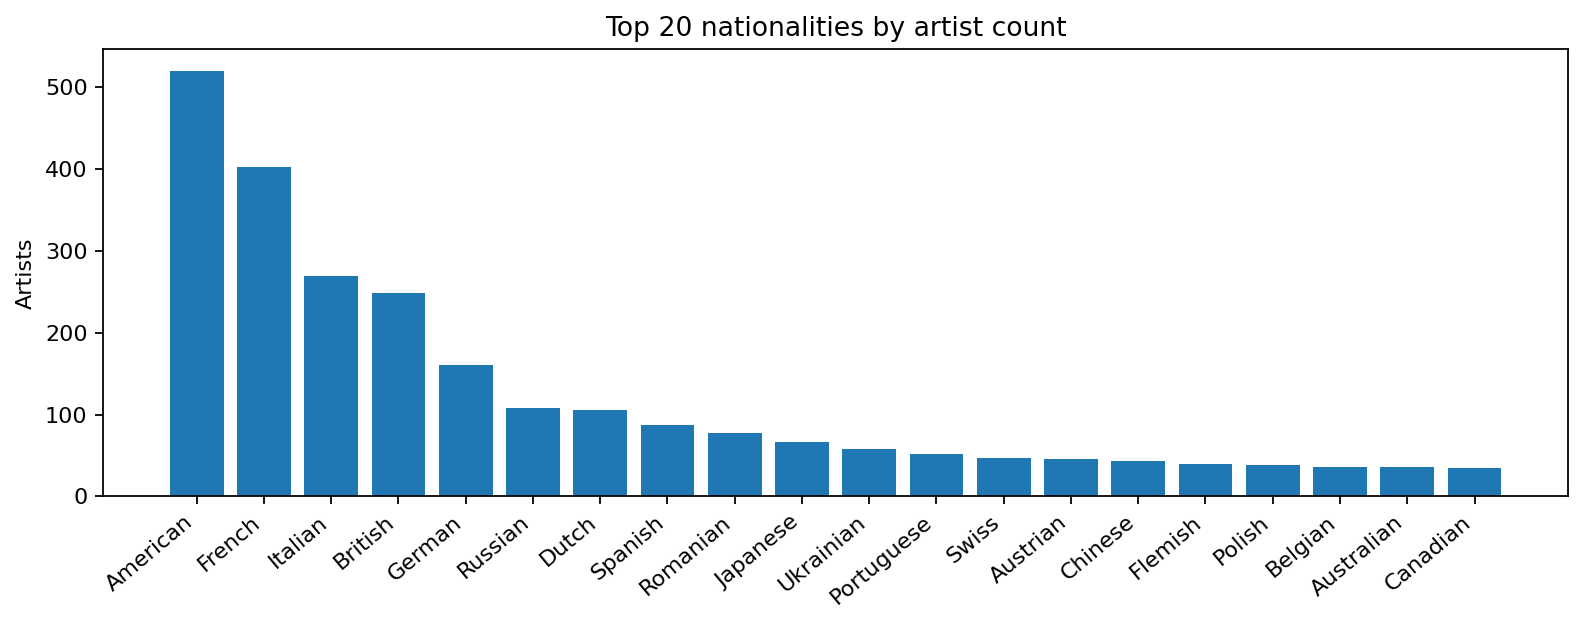

Nationality concentration (HHI): 0.0664 (0=spread, 1=monopoly)


In [ ]:
nat_counts = []
for n,d in Bnat.nodes(data=True):
    if d.get("type")=="nation":
        cnt = sum(1 for nb in Bnat.neighbors(n) if Bnat.nodes[nb].get("type")=="artist")
        nat_counts.append({"nation_node": n, "nation": d.get("name", n), "num_artists": cnt})

nat_df = pd.DataFrame(nat_counts).sort_values("num_artists", ascending=False).reset_index(drop=True)

total_artists = len(artist_nodes)
nat_df["share"] = nat_df["num_artists"] / total_artists
nat_df["cum_share"] = nat_df["share"].cumsum()

print("Top nationalities by number of artists")
display(nat_df.head(25))

print(f"\nTotal artists (graph): {total_artists:,}")
print(f"Top 5 nationalities cover: {nat_df.head(5)['share'].sum():.2%}")
print(f"Top 10 nationalities cover: {nat_df.head(10)['share'].sum():.2%}")
print(f"Top 20 nationalities cover: {nat_df.head(20)['share'].sum():.2%}")

plt.figure(figsize=(10,4))
top_k = 20
plt.bar(nat_df["nation"].head(top_k), nat_df["num_artists"].head(top_k))
plt.xticks(rotation=40, ha="right")
plt.ylabel("Artists")
plt.title(f"Top {top_k} nationalities by artist count")
plt.tight_layout()
plt.show()

hhi = np.square(nat_df["share"]).sum()
print(f"Nationality concentration (HHI): {hhi:.4f} (0=spread, 1=monopoly)")

##Which are the biggest communities in the network?

Here I’m clustering the undirected artist network using modularity (greedy) with edge weights, basically “who tends to sit in the same dense neighborhood.” The result gives big, coherent groups (sizes ~129, 108, 90) that look like stylistic or period clusters, artists who share a lot of ties end up together, so this gives me a quick map of the major sub-communities in the graph.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

if G_art_w.number_of_nodes() > 0:
    comms = list(greedy_modularity_communities(G_art_w, weight="weight"))
    comms = sorted(comms, key=len, reverse=True)
    print("Top 10 communities (greedy modularity):")
    for i, S in enumerate(comms[:10]):
        names = [G.nodes[n].get("name") for n in list(S)[:12]]
        print(f"Community {i} | size={len(S)} | examples={names}")
else:
    print("Artist–undirected graph empty.")


Top 10 communities (greedy modularity):
Community 0 | size=141 | examples=['Pieter Bruegel the Elder', '/en/pieter-codde', 'Paolo Veronese', 'Rosa Bonheur', 'Il Sodoma', 'Agostino Tassi', 'Francesco de\' Rossi (Francesco Salviati), "Cecchino"', 'Diego Velazquez', 'Wilhelm von Kaulbach', 'Luis de Madrazo y Kuntz', '/en/artists-by-painting-school/peredvizhniki-society-for-traveling-art-exhibitions', 'Giorgione']
Community 1 | size=126 | examples=['Nicolas Toussaint Charlet', 'Nathaniel Hone the Younger', '/en/artists-by-art-movement/academic-art', 'August von Pettenkofen', 'Johan Jongkind', 'Lisa Yuskavage', 'Frederic Bazille', 'Antoine Watteau', 'Walter Osborne', 'Maurice Prendergast', 'John Singer Sargent', 'Louise Abbéma']
Community 2 | size=104 | examples=['Jasper Johns', '/en/artists-by-art-movement/muralism', 'Enrique Silvestre', 'Jose Clemente Orozco', 'Helmut Federle', 'Michel Majerus', 'Hieronymus Bosch', 'Jacqueline Lamba', '/en/bernd-und-hilla-becher', '/en/artists-by-art-move

Added some plotting helpers so the next charts are clean and consistent.

In [ ]:
import numpy as np, pandas as pd, networkx as nx
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 160

PALETTE = {"artist":"#5ca9ff", "movement":"#38c172", "school":"#ffbf66", "institution":"#e86ba8", "other":"#9aa0a6"}

def node_type(n):
    return G.nodes[n].get("type","other")

def node_color(n):
    return PALETTE.get(node_type(n), PALETTE["other"])

def label_for(n, max_len=26):
    nm = str(G.nodes[n].get("name", n)).strip()
    return nm if len(nm) <= max_len else nm[:max_len-1] + "…"

def safe_ptp(arr):
    return np.ptp(arr) if isinstance(arr, np.ndarray) else (np.max(arr)-np.min(arr))


I’m building a small “ego network” around a chosen artist and plotting it.

In [ ]:
def draw_artist_egograph(artist_url, hops=1, max_nodes=140, layout="kamada"):
    assert artist_url in G, f"{artist_url} not in graph"

    nodes = set([artist_url])
    frontier = set([artist_url])
    for _ in range(hops):
        nxt = set()
        for u in list(frontier):
            nxt |= set(G.neighbors(u)) | set(G.predecessors(u)) if isinstance(G, nx.DiGraph) else set(G.neighbors(u))
        nodes |= nxt
        frontier = nxt
        if len(nodes) >= max_nodes: break

    H = G.subgraph(list(nodes)).copy()

    deg_w = {n: sum(d.get("weight",1) for _,_,d in H.edges(n, data=True)) for n in H.nodes()}
    vals = np.array([deg_w.get(n,0) for n in H.nodes()])
    sizes = 80 + 420 * (vals - vals.min()) / (safe_ptp(vals) or 1)

    if layout == "kamada":
        pos = nx.kamada_kawai_layout(H, weight=None)
    else:
        pos = nx.spring_layout(H, k=0.25, seed=42, weight=None)

    plt.figure(figsize=(9,7))
    nx.draw_networkx_edges(H, pos, alpha=0.25, width=0.6, edge_color="#bbb")

    for t, col in PALETTE.items():
        nodes_t = [n for n in H.nodes() if node_type(n)==t]
        if not nodes_t: continue
        idx = [list(H.nodes()).index(n) for n in nodes_t]
        nx.draw_networkx_nodes(
            H, pos,
            nodelist=nodes_t,
            node_color=col,
            node_size=sizes[idx],
            linewidths=1.0,
            edgecolors="#333",
            alpha=0.95,
            label=t
        )

    lbl = {artist_url: label_for(artist_url)}
    nbrs = [v for v in H.neighbors(artist_url)] + [u for u in H.predecessors(artist_url)] if isinstance(G, nx.DiGraph) else list(H.neighbors(artist_url))
    nbrs = list(set(nbrs))
    nbrs_sorted = sorted(nbrs, key=lambda n: deg_w.get(n,0), reverse=True)[:10]
    for n in [x for x in nbrs_sorted if node_type(x)!="artist"] + [x for x in nbrs_sorted if node_type(x)=="artist"][:10]:
        lbl[n] = label_for(n)
    nx.draw_networkx_labels(H, pos, labels=lbl, font_size=9)

    handles = [plt.Line2D([0],[0], marker='o', color='w', label=k, markerfacecolor=v, markersize=8) for k,v in PALETTE.items()]
    plt.legend(handles=handles, title="Node type", frameon=False, loc="lower right", ncol=2)
    plt.title(f"Ego network for: {label_for(artist_url)}  (hops={hops}, nodes={H.number_of_nodes()}, edges={H.number_of_edges()})")
    plt.axis("off"); plt.tight_layout(); plt.show()



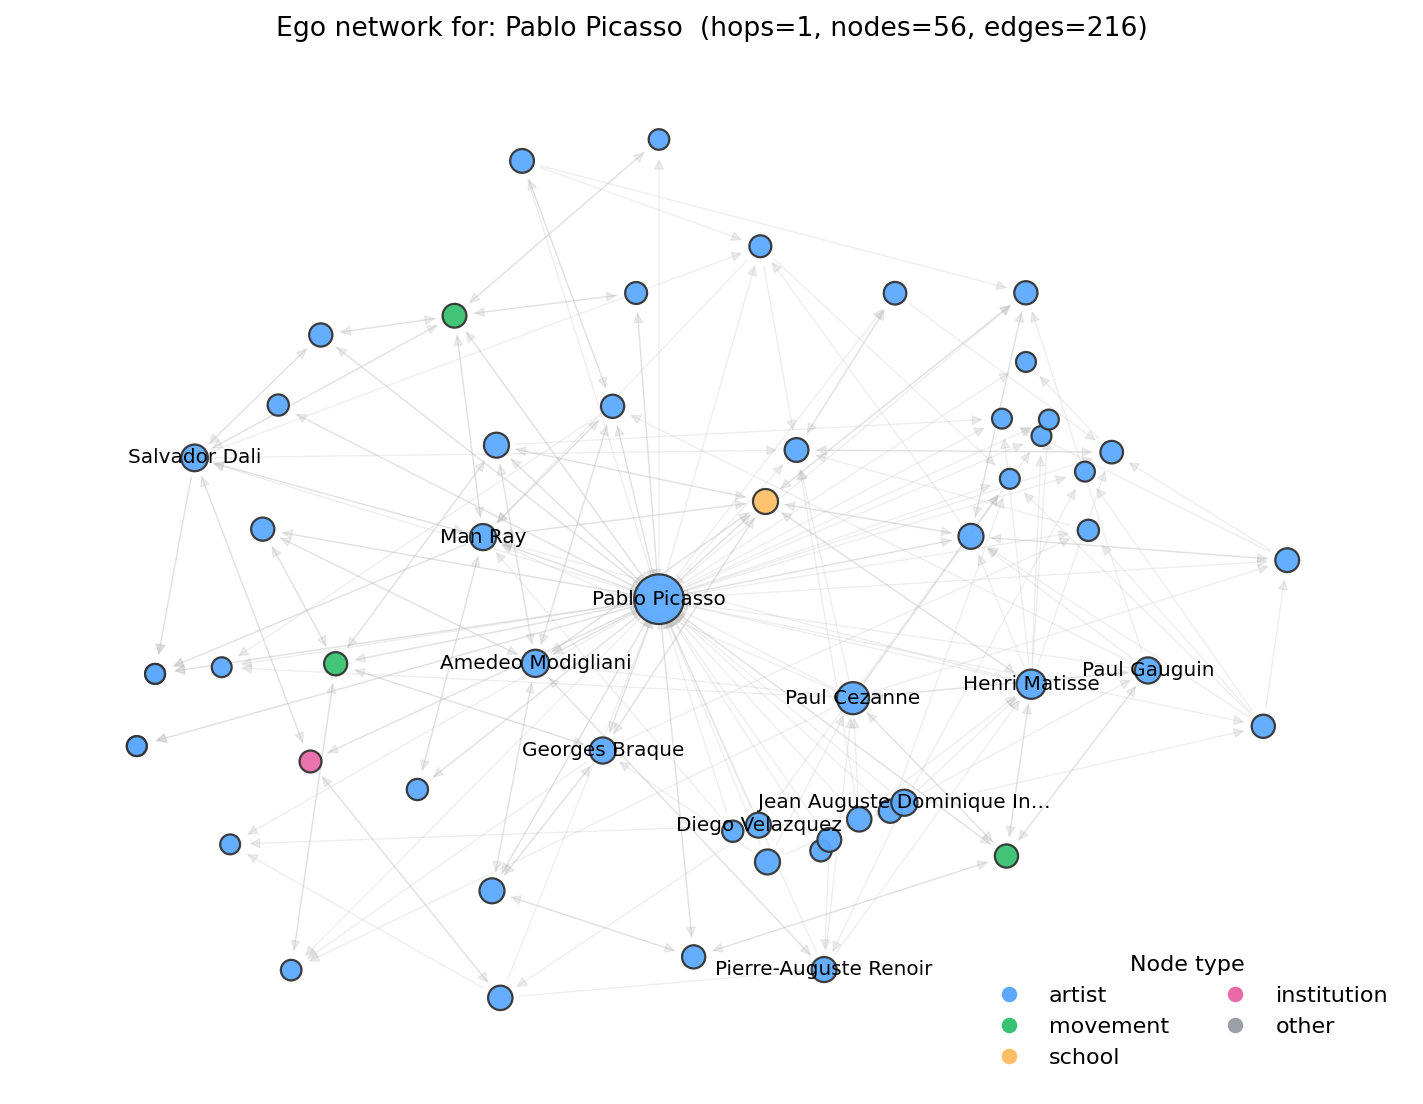

In [ ]:
draw_artist_egograph("/en/pablo-picasso", hops=1)


Plotted the six largest artist communities. Node size reflects weighted degree inside each community (more shared edges → bigger dot).

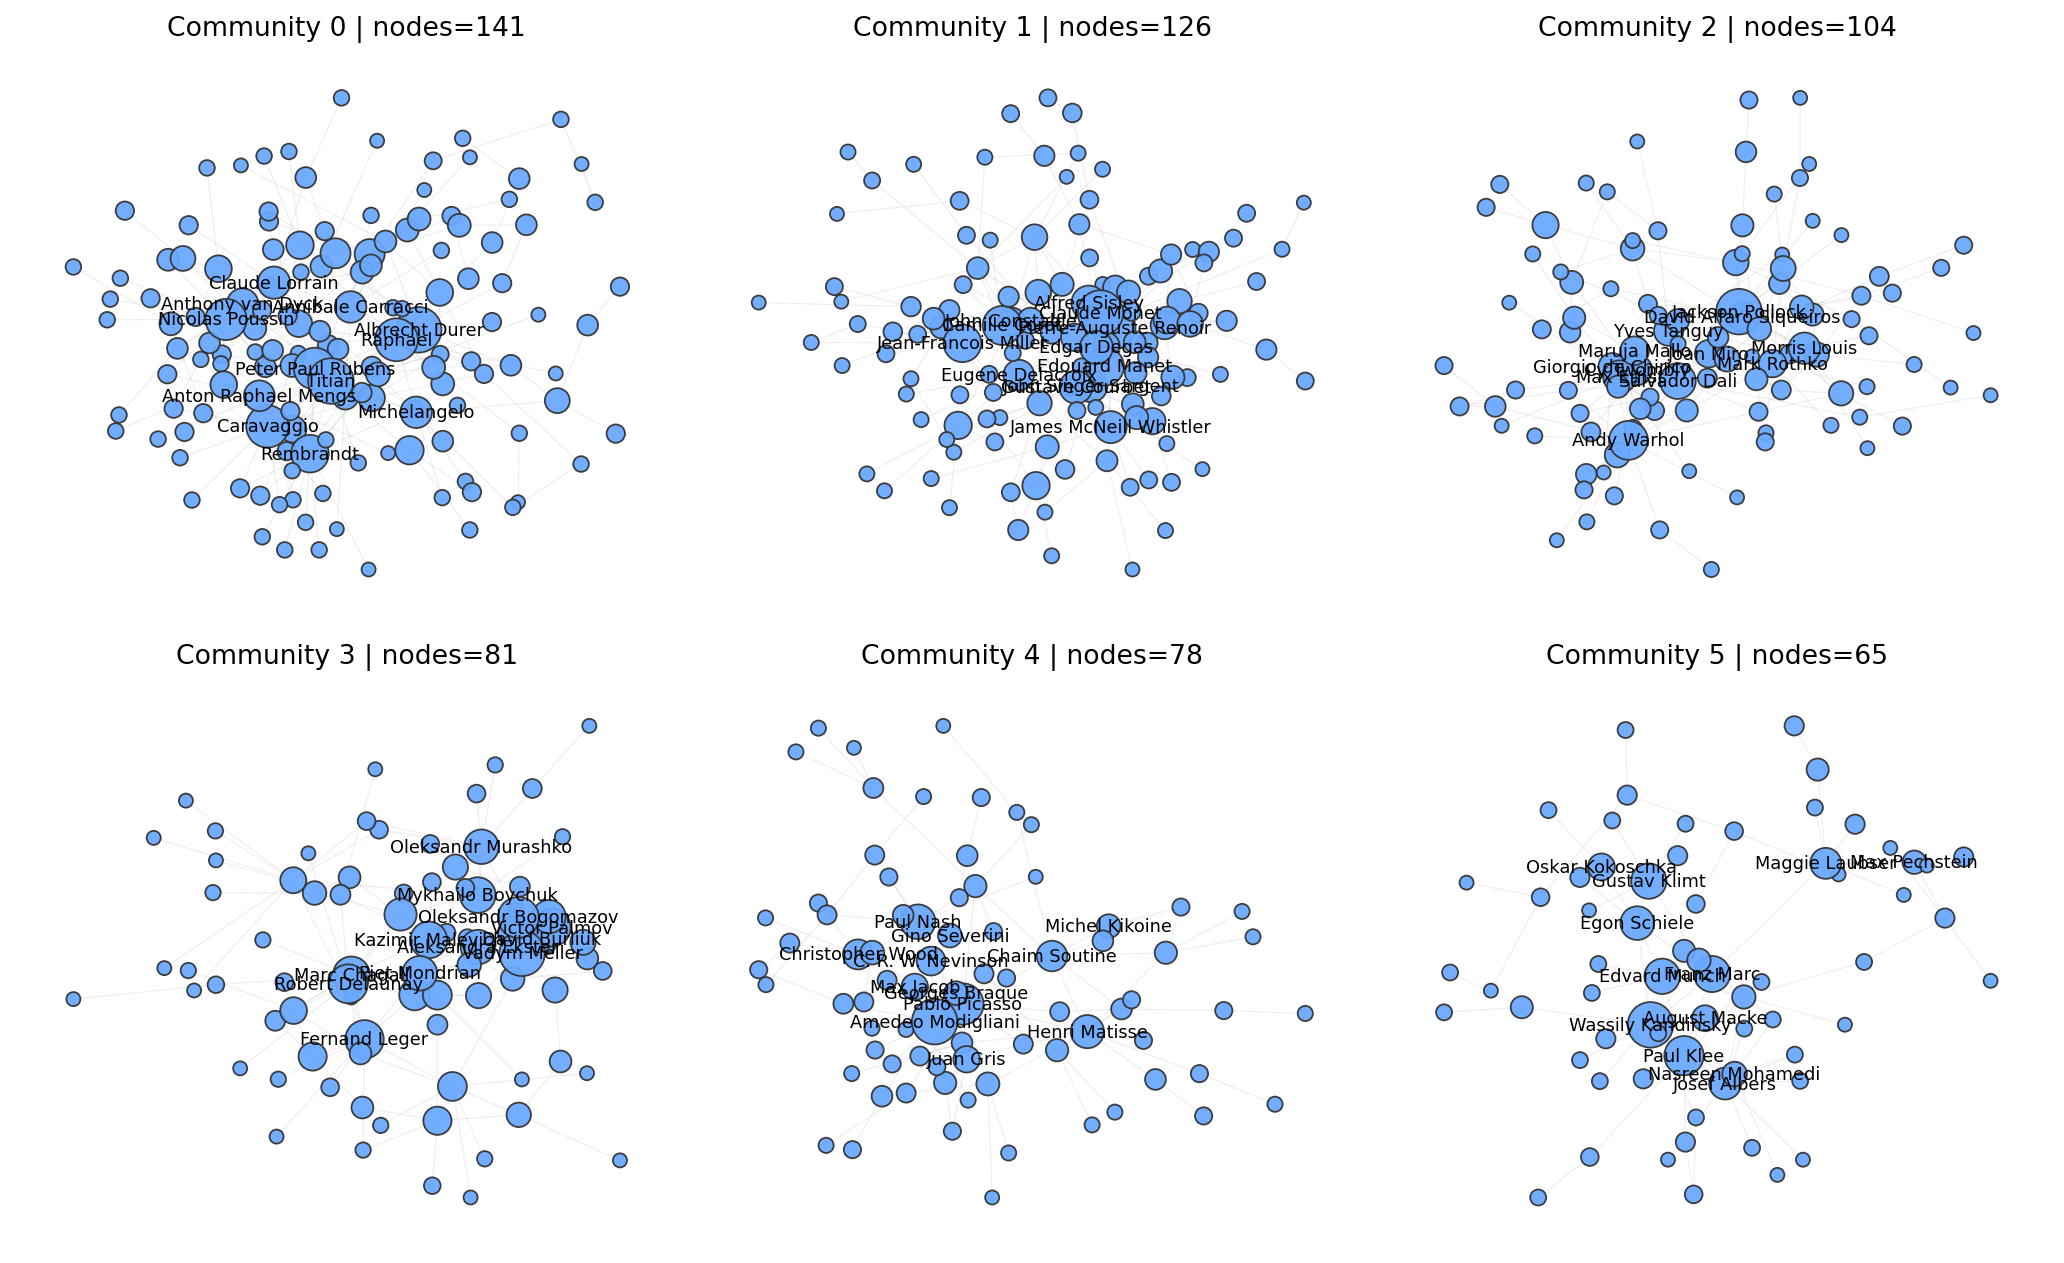

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

parts = list(greedy_modularity_communities(G_art_w, weight="weight"))

com_sizes = [(i, len(c)) for i, c in enumerate(parts)]
top_cons = [i for i, _ in sorted(com_sizes, key=lambda x: x[1], reverse=True)[:6]]

fig, axes = plt.subplots(2, 3, figsize=(13, 8))
axes = axes.ravel()[:len(top_cons)]

for ax, cid in zip(axes, top_cons):
    nodes = list(parts[cid])
    H = G_art_w.subgraph(nodes).copy()


    deg_w = {n: sum(d.get("weight", 1) for _, _, d in H.edges(n, data=True)) for n in H.nodes()}
    vals = np.array([deg_w.get(n, 0) for n in H.nodes()])
    sizes = 40 + 380 * (vals - vals.min()) / (vals.max() - vals.min() + 1e-9)

    pos = nx.spring_layout(H, k=0.35, seed=42, weight="weight")
    ax.set_title(f"Community {cid} | nodes={H.number_of_nodes()}")

    nx.draw_networkx_edges(H, pos, ax=ax, width=0.5, alpha=0.25, edge_color="#bbb")
    nx.draw_networkx_nodes(
        H, pos, ax=ax,
        node_size=sizes, node_color="#6aa9ff",
        linewidths=0.8, edgecolors="#333", alpha=0.95
    )


    top_lab = sorted(H.nodes(), key=lambda n: deg_w.get(n, 0), reverse=True)[:12]
    nx.draw_networkx_labels(H, pos, {n: label_for(n, 22) for n in top_lab}, font_size=8, ax=ax)

    ax.axis("off")

plt.tight_layout()
plt.show()


Then I took the biggest movements and asked a simple question: how many artists appear in both? Then I turned those pairwise overlaps into a heatmap, where darker squares mean more shared artists. You can see tight continuity where history expects it, Impressionism blending into Post-Impressionism, Symbolism sliding toward Art Nouveau, Expressionism feeding Surrealism, and the abstract lineage linking Abstract Art with Abstract Expressionism.

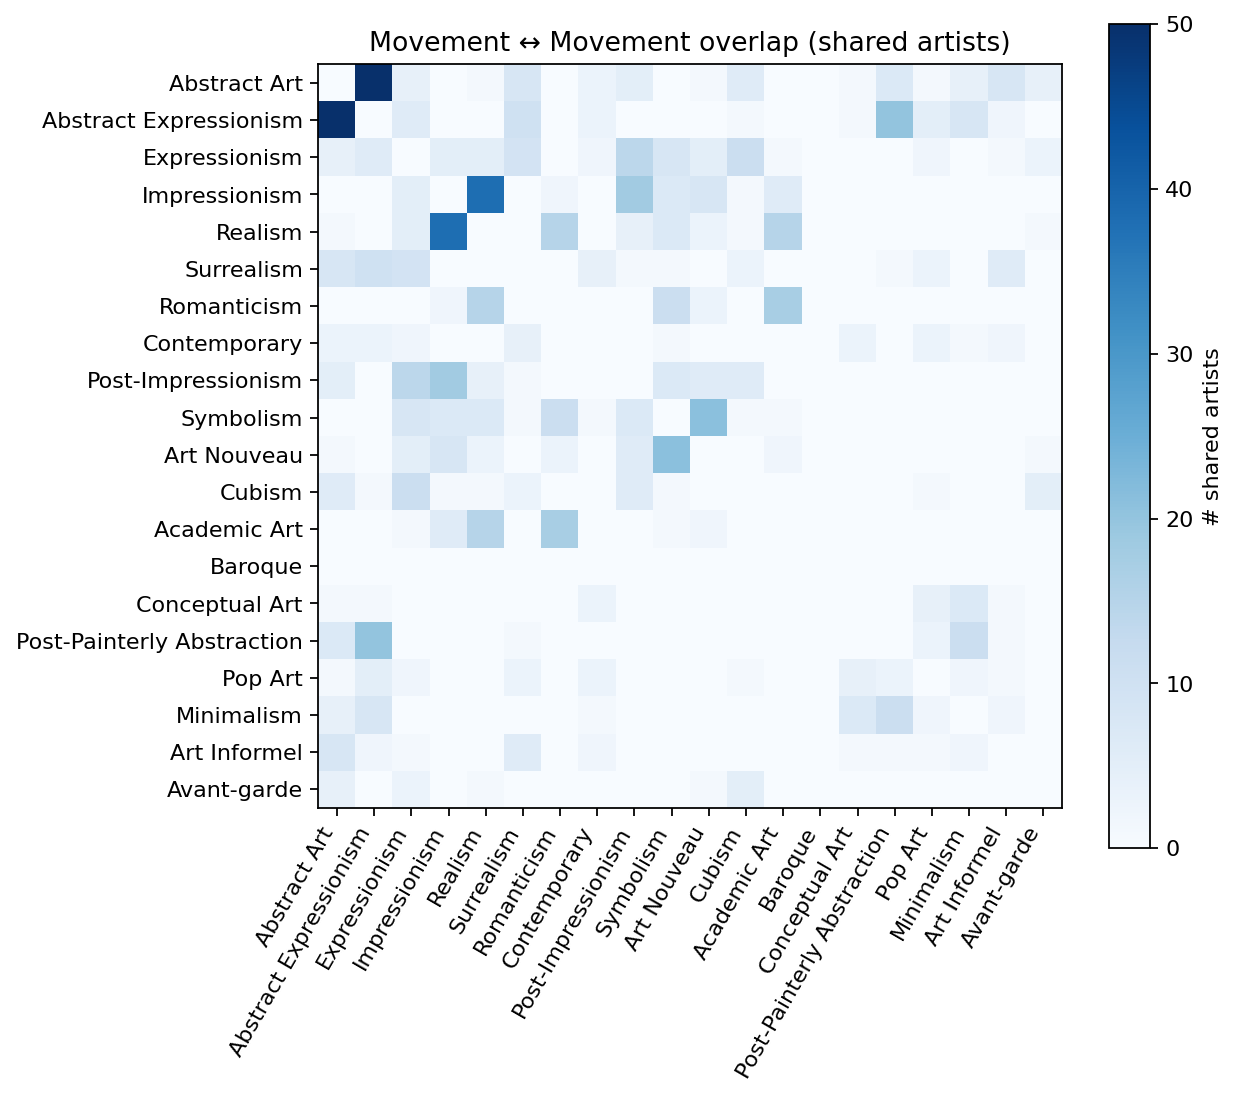

In [ ]:
movement_nodes = [n for n,d in G.nodes(data=True) if d.get("type")=="movement"]

from itertools import combinations
mv_to_art = {m: {nb for nb in G.neighbors(m) if G.nodes[nb].get("type")=="artist"} for m in movement_nodes}
shared = []
for a,b in combinations(mv_to_art.keys(), 2):
    w = len(mv_to_art[a] & mv_to_art[b])
    if w>0:
        shared.append((a,b,w))

df = pd.DataFrame(shared, columns=["m1","m2","w"])
top = (df.groupby("m1")["w"].sum().add(df.groupby("m2")["w"].sum(), fill_value=0).sort_values(ascending=False).head(20).index)
df_top = df[df["m1"].isin(top) & df["m2"].isin(top)]

labels = [n for n in top]
idx = pd.Index(labels, name="movement")
mat = pd.DataFrame(0, index=idx, columns=idx)
for a,b,w in df_top.itertuples(index=False):
    mat.at[a,b] = w
    mat.at[b,a] = w

fig, ax = plt.subplots(figsize=(8,7))
im = ax.imshow(mat.values, cmap="Blues")
ax.set_xticks(range(len(labels))); ax.set_xticklabels([G.nodes[m].get("name",m) for m in labels], rotation=60, ha="right")
ax.set_yticks(range(len(labels))); ax.set_yticklabels([G.nodes[m].get("name",m) for m in labels])
ax.set_title("Movement ↔ Movement overlap (shared artists)")
fig.colorbar(im, ax=ax, label="# shared artists")
plt.tight_layout(); plt.show()


Here I’m pulling one movement and showing its member artists so we can see who’s in the club. The movement sits on the left as a single node; to the right I lay out a slice of its artists.

In [ ]:
def draw_movement_members(movement_node, max_artists=80):
    assert G.nodes[movement_node].get("type")=="movement"
    arts = [a for a in G.neighbors(movement_node) if G.nodes[a].get("type")=="artist"]
    arts = sorted(arts, key=lambda a: int(G.degree(a)), reverse=True)[:max_artists]

    H = nx.Graph()
    H.add_node(movement_node, side=0)
    for a in arts:
        H.add_node(a, side=1)
        H.add_edge(movement_node, a)

    pos = {}
    pos[movement_node] = (0, 0.5)
    for i,a in enumerate(arts):
        pos[a] = (1, 1 - (i+1)/(len(arts)+1))

    plt.figure(figsize=(7, min(8, 2+0.07*len(arts))))
    nx.draw_networkx_edges(H, pos, alpha=0.2, width=0.8, edge_color="#888")
    nx.draw_networkx_nodes(H, pos, nodelist=[movement_node], node_color=PALETTE["movement"], node_size=600, edgecolors="#333")
    nx.draw_networkx_labels(H, pos, labels={movement_node: label_for(movement_node, 30)}, font_size=11)

    nx.draw_networkx_nodes(H, pos, nodelist=arts, node_color=PALETTE["artist"], node_size=120, edgecolors="#333", linewidths=0.5)
    nx.draw_networkx_labels(H, pos, labels={a:label_for(a, 22) for a in arts}, font_size=8, verticalalignment="center")

    plt.title(f"Artists in {G.nodes[movement_node].get('name', movement_node)}  (showing {len(arts)} of {len([*G.neighbors(movement_node)])})")
    plt.axis("off"); plt.tight_layout(); plt.show()


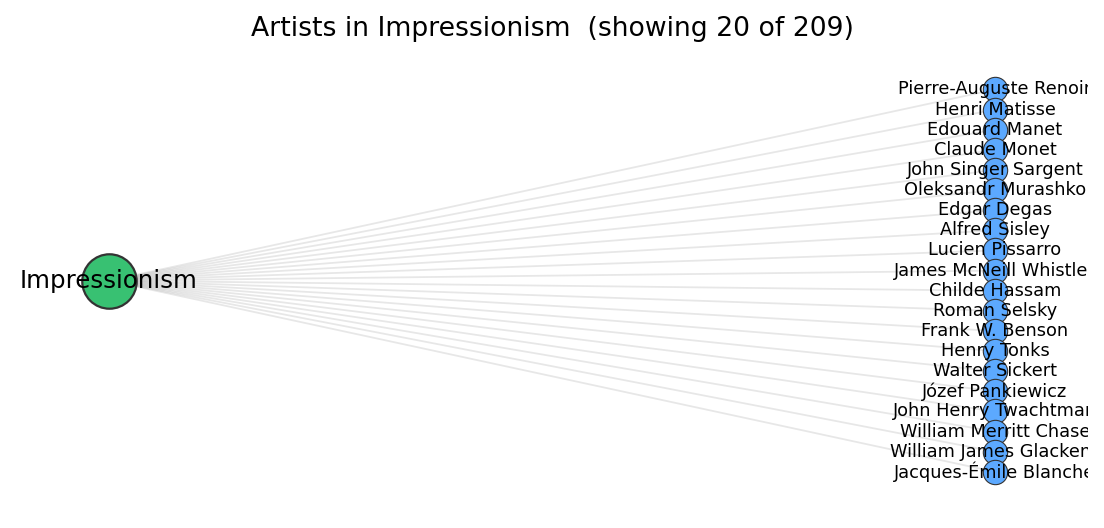

In [ ]:
mv = "movement::impressionism"
draw_movement_members(mv, max_artists=20)


##Interactive visualization

In [ ]:
import math
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from collections import Counter

G_view = G

def ensure_attributes(view_graph, base_graph=None):
    if base_graph is None:
        return
    for n in view_graph.nodes():
        if n in base_graph:
            view_graph.nodes[n].update(base_graph.nodes[n])

try:
    G
    ensure_attributes(G_view, G)
except NameError:
    pass

PALETTE = {
    "artist":       "#5ca9ff",
    "movement":     "#38c172",
    "school":       "#ffbf66",
    "institution":  "#e86ba8",
    "other":        "#9aa0a6",
}


def safe_ptp(arr):
    try:
        rng = float(np.max(arr) - np.min(arr))
        return rng if rng > 0 else 1.0
    except Exception:
        return 1.0

def node_type(n, G=G_view):
    d = G.nodes[n]
    t = d.get("type", None)

    if t is None:
        return "other"
    if isinstance(t, float):
        try:
            if math.isnan(t):
                return "other"
        except Exception:
            pass

    if isinstance(t, (list, tuple, set)):
        t = next((x for x in t if x is not None and str(x).strip() != ""), "other")

    t = str(t).strip().lower()

    alias = {
        "artists": "artist",
        "movement": "movement",
        "movements": "movement",
        "school": "school",
        "schools": "school",
        "institution": "institution",
        "institutions": "institution",
    }
    return alias.get(t, t) if t in alias or t in PALETTE else ("other" if t == "" else t)

def weighted_degree_undirected(G):
    H = G.to_undirected() if G.is_directed() else G
    deg = Counter()
    if isinstance(H, (nx.MultiGraph, nx.MultiDiGraph)):
        for u, v, d in H.edges(data=True):
            w = float(d.get("weight", 1.0))
            deg[u] += w
            deg[v] += w
    else:
        for u, v, d in H.edges(data=True):
            w = float(d.get("weight", 1.0))
            deg[u] += w
            deg[v] += w
    return dict(deg)

def nice_layout(G, dim=2, seed=42, method="spring"):
    if method == "kamada":
        try:
            return nx.kamada_kawai_layout(G, dim=dim, weight="weight")
        except Exception:
            pass
    return nx.spring_layout(G, dim=dim, seed=seed, k=None, weight="weight")

pos = nice_layout(G_view, dim=2, seed=42, method="spring")

nodes = list(G_view.nodes())
deg_w = weighted_degree_undirected(G_view)
deg_vals = np.array([deg_w.get(n, 0.0) for n in nodes], dtype=float)
sizes = 10.0 + 28.0 * (deg_vals - deg_vals.min()) / safe_ptp(deg_vals)

types_present = sorted(set(node_type(n, G_view) for n in nodes))
type_to_nodes = {t: [n for n in nodes if node_type(n, G_view) == t] for t in types_present}


xe, ye = [], []
for u, v in G_view.edges():
    xu, yu = pos[u]
    xv, yv = pos[v]
    xe += [xu, xv, None]
    ye += [yu, yv, None]

edge_trace = go.Scatter(
    x=xe, y=ye,
    mode="lines",
    line=dict(width=0.8, color="#bdbdbd"),
    hoverinfo="skip",
    showlegend=False,
    opacity=0.35
)

node_traces = []
for t, ns in type_to_nodes.items():
    if not ns:
        continue
    xi = [pos[n][0] for n in ns]
    yi = [pos[n][1] for n in ns]
    si = [10.0 + 28.0 * (deg_w.get(n, 0.0) - deg_vals.min()) / safe_ptp(deg_vals) for n in ns]
    hover = [
        f"<b>{G_view.nodes[n].get('name', n)}</b>"
        f"<br>type: {node_type(n, G_view)}"
        f"<br>nation: {G_view.nodes[n].get('nation', '—')}"
        for n in ns
    ]
    node_traces.append(go.Scatter(
        x=xi, y=yi,
        mode="markers",
        name=t,
        hoverinfo="text",
        text=hover,
        marker=dict(
            size=si,
            color=PALETTE.get(t, PALETTE["other"]),
            line=dict(width=1, color="#1f2937"),
            opacity=0.95
        )
    ))

fig = go.Figure([edge_trace] + node_traces)
fig.update_layout(
    title_x=0.5,
    width=950, height=800,
    paper_bgcolor="white",
    plot_bgcolor="white",
    showlegend=True,
    legend=dict(itemsizing="trace", orientation="h", yanchor="bottom", y=1.02),
    margin=dict(l=10, r=10, t=60, b=10),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)
fig.show()

print("Type counts in view:", Counter(node_type(n, G_view) for n in G_view.nodes()))


Type counts in view: Counter({'artist': 3155, 'school': 273, 'movement': 177, 'institution': 88})
